<a href="https://colab.research.google.com/github/faizanahemad/eva/blob/master/assignment-9/Assignment_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade --upgrade-strategy only-if-needed https://github.com/faizanahemad/data-science-utils/tarball/master > /dev/null
!pip install git+https://www.github.com/keras-team/keras-contrib.git > /dev/null
!pip install keract > /dev/null


  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-c_q9lemj


In [2]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, balanced_accuracy_score, accuracy_score
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, DepthwiseConv2D, Conv2D, SeparableConv2D, AveragePooling2D
from keras.layers import Input, concatenate
from keras.layers import Activation, Flatten, Dense, Dropout, Lambda, SpatialDropout2D, Add
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Nadam, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.regularizers import l2
%config InlineBackend.figure_format='retina'
from keras_contrib.callbacks import CyclicLR
from keras.models import Model
import tensorflow as tf
import cv2
from google.colab.patches import cv2_imshow
import random
from data_science_utils.vision.keras import *
from IPython.core.interactiveshell import InteractiveShell
import matplotlib.gridspec as gridspec

import gc

InteractiveShell.ast_node_interactivity = "all"

Using TensorFlow backend.


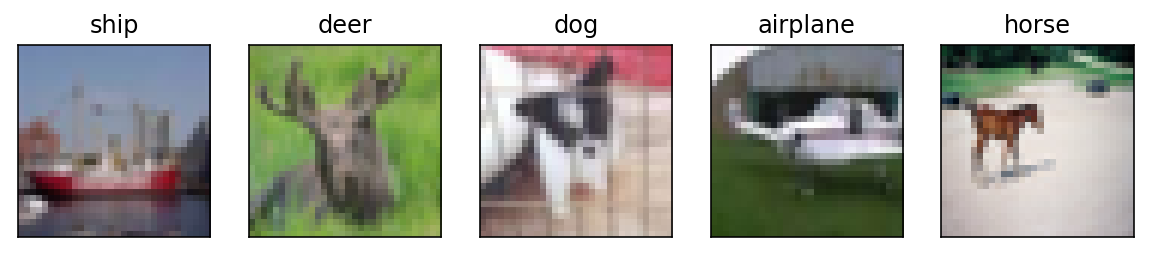

In [3]:
X_train, Y_train, X_test, Y_test = get_cifar10_data()
classes = get_cifar10_labels()
show_examples(X_train[10:15], Y_train[10:15], classes)

# Lib

In [0]:

def dense_block(inputs,name, start_kernels = 16, increase_kernels = 32, n_layers = 4, n_groups = 2,
                pool=False, spatial_dropout = 0.1, 
                enable_transition = True,transition_layer_kernels = 32,
                enable_skip = True,skip_layer_kernels = 32, pool_skip=False,pool_skip_factor=0.2):
  
  inputs = concat_s2d(inputs)
  out = transition_layer(inputs,name+"tran_1", transition_layer_kernels) if enable_transition else inputs
  skip = transition_layer(inputs,name+"tran_2", skip_layer_kernels) if enable_skip else inputs
#   skip = inputs
  assert K.int_shape(out)[-1] >= n_groups*2
  outs = [out]
  
  for i in range(n_layers):
    
    assert int((start_kernels + i*increase_kernels)/n_groups) >= 2
    bn_zero_gamma = i== (n_layers-1)
    out_0 = concat_s2d(outs)
    in_channels = K.int_shape(out_0)[-1]
    grp_outs = []
    out_grp = None
    n_kernels = int((start_kernels + i*increase_kernels)/n_groups)
    if i== n_layers-1:
      n_kernels = n_kernels - (int(increase_kernels/n_groups) + 8)
    for group in range(n_groups):
      
      out_grp = Lambda(lambda x: x[:, :, :, int(group*in_channels/n_groups): int((group+1)*in_channels/n_groups)])(out_0)
      nm = name+"layer_"+str(i)+"group_"+str(group)
      if group%2==0:
        out_grp = depthwise_conv_layer(out_grp,name=nm+"_sep-conv_",n_kernels=n_kernels,
                                       bn_zero_gamma=bn_zero_gamma)
      else:
        out_grp = conv_layer(out_grp,name=nm+"_conv_",n_kernels=n_kernels,
                             bn_zero_gamma=bn_zero_gamma)
      grp_outs.append(out_grp)
      #
    assert len(grp_outs)==n_groups
    grp_outs = channel_shuffle(grp_outs)
    outs.append(grp_outs)
  outs = outs[1:]
  outs = concat_s2d(outs)
  outs = AveragePooling2D(name=name+"MP")(outs) if pool else outs
  if enable_skip:
    outs = [outs,skip]
  else:
    outs = [outs]
  if pool and pool_skip:
    outs = concat_s2d(outs)
    out = transition_layer(outs,name+"pool_skip_tran", int(K.int_shape(outs)[-1]*pool_skip_factor))
    outs = [out,outs]
  outs = concat_s2d(outs)
  outs = SpatialDropout2D(spatial_dropout, name=name+"SDrop")(outs) if spatial_dropout>0 else outs
  
  return outs


def output_layer(inputs, n_classes,transition_kernels=40):
  inputs = concat_s2d(inputs)
  out = transition_layer(inputs,"output_transition", transition_kernels,bn=False)
  
  out = Conv2D(n_classes,
          kernel_size=1,
          strides=1,
          kernel_regularizer=l2(1e-4),
          dilation_rate=1)(out)
  
  out = GlobalAveragePooling2D()(out)
  out = Activation("softmax")(out)
  return out
  
  
  



In [0]:
def min_max_scale(X):
  return (X - np.min(X))/(np.max(X)-np.min(X))

class MakeIter(object):
    def __init__(self, *args, **kwargs):
        self.generator_func = args[0]
        self.kwargs = kwargs
        self.args = args[2:]
        self.length = args[1]
        self.iter = self.generator_func(*self.args,**self.kwargs)
        
        
    def __iter__(self):
        return self.iter
        
    def __len__(self): 
        return self.length
    def __next__(self):
        return next(self.iter)
        
    def next(self):
        return next(self.iter)

In [0]:
# https://stackoverflow.com/questions/34643747/ipython-notebook-jupyter-opencv-cv2-and-plotting/48738145#48738145
# https://stackoverflow.com/questions/34933905/matplotlib-adding-subplots-to-a-subplot
def gradcam(model,layer,img,normalized_input=True,show=False):
  if not normalized_input:
    img = img/255
  x = np.expand_dims(img, axis=0)
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(layer)
  layer_out_channels = last_conv_layer.output_shape[-1]
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(layer_out_channels):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  
  heatmap = heatmap/255
  
#   superimposed_img = cv2.addWeighted(img, 0.75, heatmap, 0.25, 0)
  superimposed_img = 0.7*(img) + 0.3*heatmap
  superimposed_img = superimposed_img
  if show:
    plt.imshow(img)
    plt.show()
    plt.imshow(heatmap)
    plt.show()
    plt.imshow(superimposed_img)
    plt.show()
  return img,heatmap,superimposed_img


def show_examples_with_gradcam(model,layer,X,Y,classes,image_size_multiplier=2):
  Y = np.argmax(Y, axis=1)
  columns = 5
  rows = int(np.ceil(len(X) / columns))
  
  fig_height = rows * image_size_multiplier * 3
  fig_width = columns * image_size_multiplier
  fig = plt.figure(figsize=(fig_width, fig_height))
  outer = gridspec.GridSpec(rows, columns, wspace=0.0, hspace=0.2)
  for i in range(rows*columns):
    if i>=len(X):
      break
    x = X[i]
    y = Y[i]
    img,heatmap,superimposed_img = gradcam(model,layer,x,show=False)
    inner = gridspec.GridSpecFromSubplotSpec(3, 1,
                    subplot_spec=outer[i], wspace=0.0, hspace=0.15)
    imgs = [img,heatmap,superimposed_img]
    titles = ["Image: "+classes[y],"HeatMap","SuperImposed Image"]
    for j in range(3):
        ax = plt.Subplot(fig, inner[j])
        ax.imshow(imgs[j])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(titles[j])
        fig.add_subplot(ax)
  
  fig.show()   
  

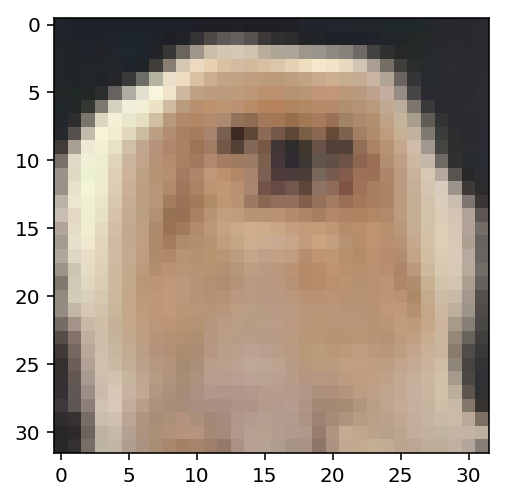

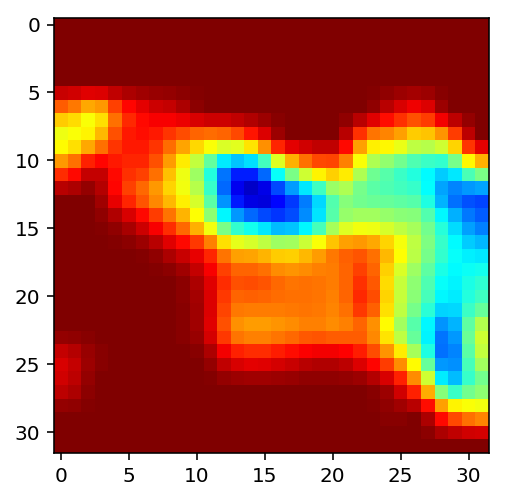

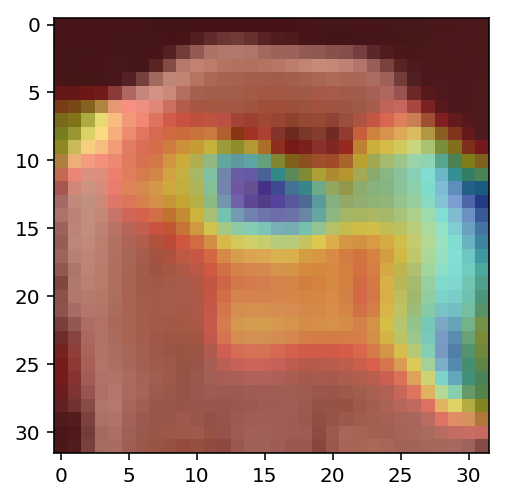

In [14]:
_ = gradcam(model,"output_transition",X_e[0],show=True)

# Test Images

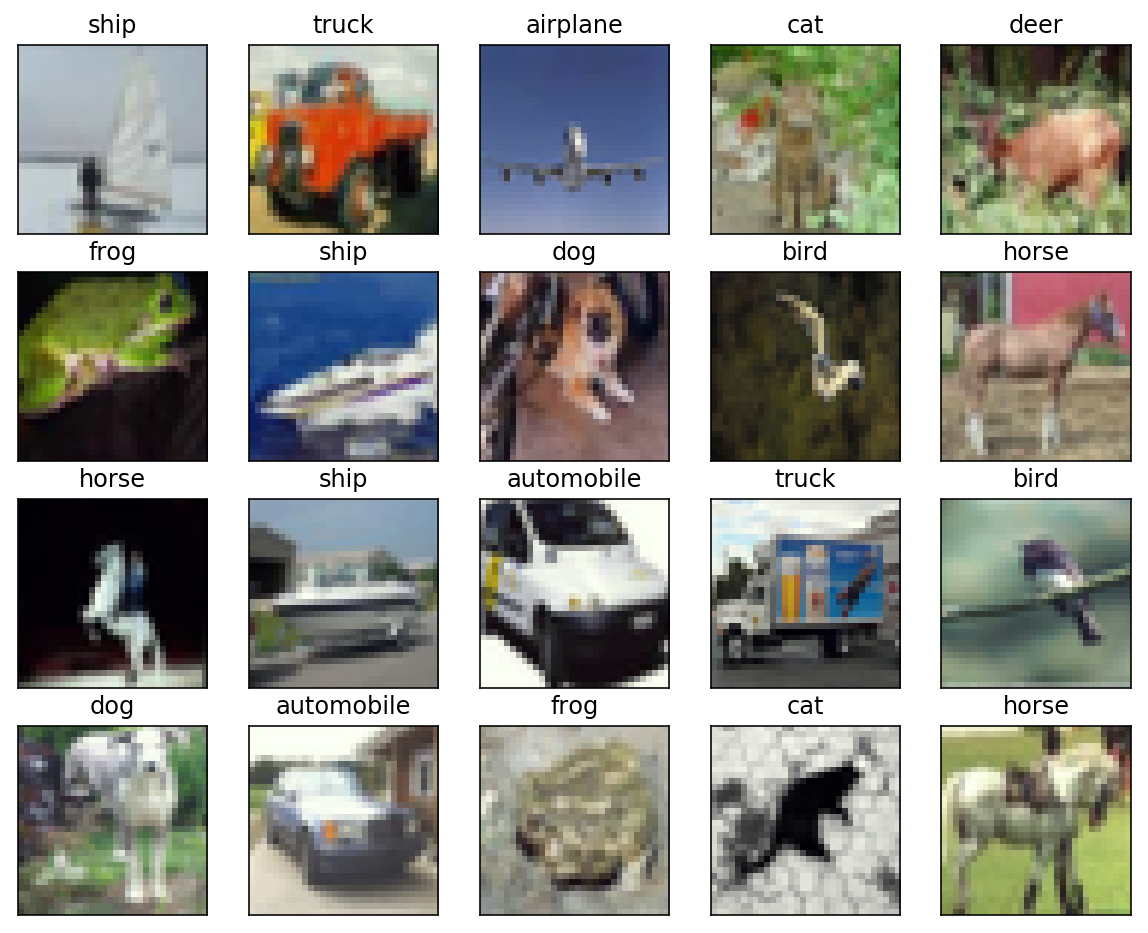

In [92]:
X_train, Y_train, X_test, Y_test = get_cifar10_data(preprocess=False)
datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,)
_ = datagen.fit(X_train)
train_iterator = datagen.flow(X_train, Y_train, batch_size=100,shuffle=False)

X_e, Y_e = train_iterator.next()
X_e = min_max_scale(X_e)
show_examples(X_e[10:30], Y_e[10:30], classes)




In [0]:
gc.collect()
print()

In [0]:
def build_model():
  gc.collect()
  inputs = Input(shape=(32,32,3))
  x = conv_layer(inputs,name="initial_conv_",n_kernels=48, padding='same')
  x = conv_layer(x,name="2nd_conv_",n_kernels=64, padding='same')
  x0 = x
  x = conv_layer(x,name="3nd_conv_",n_kernels=96, padding='same')
  x1 = x
  x = SpatialDropout2D(0.05)(x)
  xd1 = conv_layer(x,name="1_dilated_conv_",n_kernels=48, padding='same',dilation_rate=2)


  x = concat_s2d([x,xd1,x0])
  x = dense_block(x,name="dense_1_", start_kernels = 48, increase_kernels = 32, n_layers = 3, n_groups = 2,
                  pool=True, spatial_dropout = 0.1,
                  enable_transition = True,transition_layer_kernels = 48,
                  enable_skip = False,skip_layer_kernels = 0)
  d1 = x
  xd3 = transition_layer(x,"dilated_tran_1", 64)
  xd3 = conv_layer(xd3,name="3_dilated_conv_",n_kernels=48, padding='same',dilation_rate=2)
  x = concat_s2d([x,x1,xd3])
  print(K.int_shape(x))
  x = dense_block(x,name="dense_2_", start_kernels = 64, increase_kernels = 32, n_layers = 3, n_groups = 2,
                  pool=False, spatial_dropout = 0.2, 
                  enable_transition = True,transition_layer_kernels = 72,
                  enable_skip = True,skip_layer_kernels = 128)

  d2 = x
  d2 = transition_layer(d2,"skip_tran_1", 96)
  x = concat_s2d([x,x1])
  print(K.int_shape(x))
  x = dense_block(x,name="dense_3_", start_kernels = 48, increase_kernels = 32, n_layers = 3, n_groups = 2,
                  pool=True, spatial_dropout = 0.25, 
                  enable_transition = True,transition_layer_kernels = 64,
                  enable_skip = True,skip_layer_kernels = 48)


  x = concat_s2d([x,xd3])
  print(K.int_shape(x))
  x = dense_block(x,name="dense_4_", start_kernels = 48, increase_kernels = 32, n_layers = 2, n_groups = 2,
                  pool=False, spatial_dropout = 0.1, 
                  enable_transition = True,transition_layer_kernels = 64,
                  enable_skip = True,skip_layer_kernels = 64)

  # Output

  x = concat_s2d([x,d2,xd3])
  print(K.int_shape(x))
  output = output_layer(x,10,192)

  model = Model(inputs=inputs, outputs=output)

  optimizer = Adam(lr=0.0005,)


  model.compile(loss=prediction_smoothing_categorical_cross_entropy(samples=X_train.shape[0],batch_size=256,rate=1.05),
               optimizer=optimizer,
               metrics=['accuracy'])
  print("Model Params = ",model.count_params())
  print("Layer Names: ",[layer.name for layer in model.layers[0:]])
  return model



# Before Cutout

In [101]:
model = build_model()

(None, 16, 16, 624)
(None, 16, 16, 752)
(None, 8, 8, 576)
(None, 8, 8, 720)
Model Params =  869342
Layer Names:  ['input_15', 'initial_conv_conv_', 'initial_conv_bn_', 'initial_conv_activation_', '2nd_conv_conv_', '2nd_conv_bn_', '2nd_conv_activation_', '3nd_conv_conv_', '3nd_conv_bn_', '3nd_conv_activation_', 'spatial_dropout2d_15', '1_dilated_conv_conv_', '1_dilated_conv_bn_', '1_dilated_conv_activation_', 'concatenate_421', 'dense_1_tran_1', 'batch_normalization_111', 'activation_139', 'lambda_546', 'lambda_547', 'dense_1_layer_0group_0_sep-conv_sep-conv_', 'dense_1_layer_0group_1_conv_conv_', 'dense_1_layer_0group_0_sep-conv_bn_', 'dense_1_layer_0group_1_conv_bn_', 'dense_1_layer_0group_0_sep-conv_activation_', 'dense_1_layer_0group_1_conv_activation_', 'concatenate_422', 'lambda_548', 'concatenate_423', 'lambda_549', 'lambda_550', 'dense_1_layer_1group_0_sep-conv_sep-conv_', 'dense_1_layer_1group_1_conv_conv_', 'dense_1_layer_1group_0_sep-conv_bn_', 'dense_1_layer_1group_1_conv_bn

In [102]:

X_train, Y_train, X_test, Y_test = get_cifar10_data(preprocess=False)
# datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True, 
#                             horizontal_flip=True,channel_shift_range=0.3,zoom_range=0.1,
#                              height_shift_range=0.2,width_shift_range=0.1,rotation_range=10, 
#                              preprocessing_function=get_cutout_eraser(p=0.75, s_l=0.05, s_h=0.2, r_1=0.3, r_2=1 / 0.3, max_erasures_per_image=1, pixel_level=True))
datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True)

datagen_validation = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,)
datagen.fit(X_train)
datagen_validation.fit(X_train)

train_iterator = datagen.flow(X_train, Y_train, batch_size=256,shuffle=True)
validation_iterator = datagen_validation.flow(X_test, Y_test, batch_size=512,shuffle=True)

checkpoint = ModelCheckpoint("model-m5-50.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')

# clr = CyclicLR(base_lr=0.0001, max_lr=0.005,step_size=800, mode='triangular2')
lr_manager = OneCycleLR(samples=X_train.shape[0], epochs=10, batch_size=256,
                        steps=len(train_iterator), max_lr=0.005,
                        end_percentage=0.1, scale_percentage=None,
                        maximum_momentum=None, minimum_momentum=None)

callbacks_list = [checkpoint,lr_manager]
train_history = model.fit_generator(train_iterator,
                    steps_per_epoch=len(train_iterator), 
                    validation_data = validation_iterator, 
                    validation_steps = len(validation_iterator),
                    epochs=10, verbose=2,
                    callbacks=callbacks_list,)



model.load_weights("model-m5-50.hdf5")


iterator = datagen_validation.flow(X_train, Y_train, batch_size=256, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen_validation.flow(X_train, Y_train, batch_size=256, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = inspect_predictions(score, predictions,Y_train, classes=get_cifar10_labels(),print_results=True, plot_results=False)


iterator = datagen_validation.flow(X_test, Y_test, batch_size=256, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen_validation.flow(X_test, Y_test, batch_size=256, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = inspect_predictions(score, predictions,Y_test, classes=get_cifar10_labels(),print_results=True, plot_results=False)

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.903165). Check your callbacks.
  % delta_t_median)


 - 98s - loss: 1.6793 - acc: 0.4469 - val_loss: 3.6275 - val_acc: 0.2897
 - lr: 0.00149 
Epoch 2/10
 - 87s - loss: 1.2220 - acc: 0.6161 - val_loss: 2.2448 - val_acc: 0.4344
 - lr: 0.00249 
Epoch 3/10
 - 87s - loss: 1.0236 - acc: 0.6933 - val_loss: 1.7387 - val_acc: 0.5348
 - lr: 0.00349 
Epoch 4/10
 - 87s - loss: 0.9119 - acc: 0.7396 - val_loss: 1.1821 - val_acc: 0.6497
 - lr: 0.00449 
Epoch 5/10
 - 87s - loss: 0.8434 - acc: 0.7722 - val_loss: 0.9170 - val_acc: 0.7473
 - lr: 0.00451 
Epoch 6/10
 - 87s - loss: 0.7514 - acc: 0.8054 - val_loss: 0.9927 - val_acc: 0.7148
 - lr: 0.00351 
Epoch 7/10
 - 87s - loss: 0.6692 - acc: 0.8350 - val_loss: 0.8258 - val_acc: 0.7853
 - lr: 0.00251 
Epoch 8/10
 - 87s - loss: 0.5757 - acc: 0.8640 - val_loss: 0.6653 - val_acc: 0.8319
 - lr: 0.00151 
Epoch 9/10
 - 87s - loss: 0.4767 - acc: 0.8957 - val_loss: 0.6348 - val_acc: 0.8399
 - lr: 0.00051 
Epoch 10/10
 - 87s - loss: 0.3846 - acc: 0.9269 - val_loss: 0.5177 - val_acc: 0.8795
 - lr: 0.00001 
 =-=  =-= 

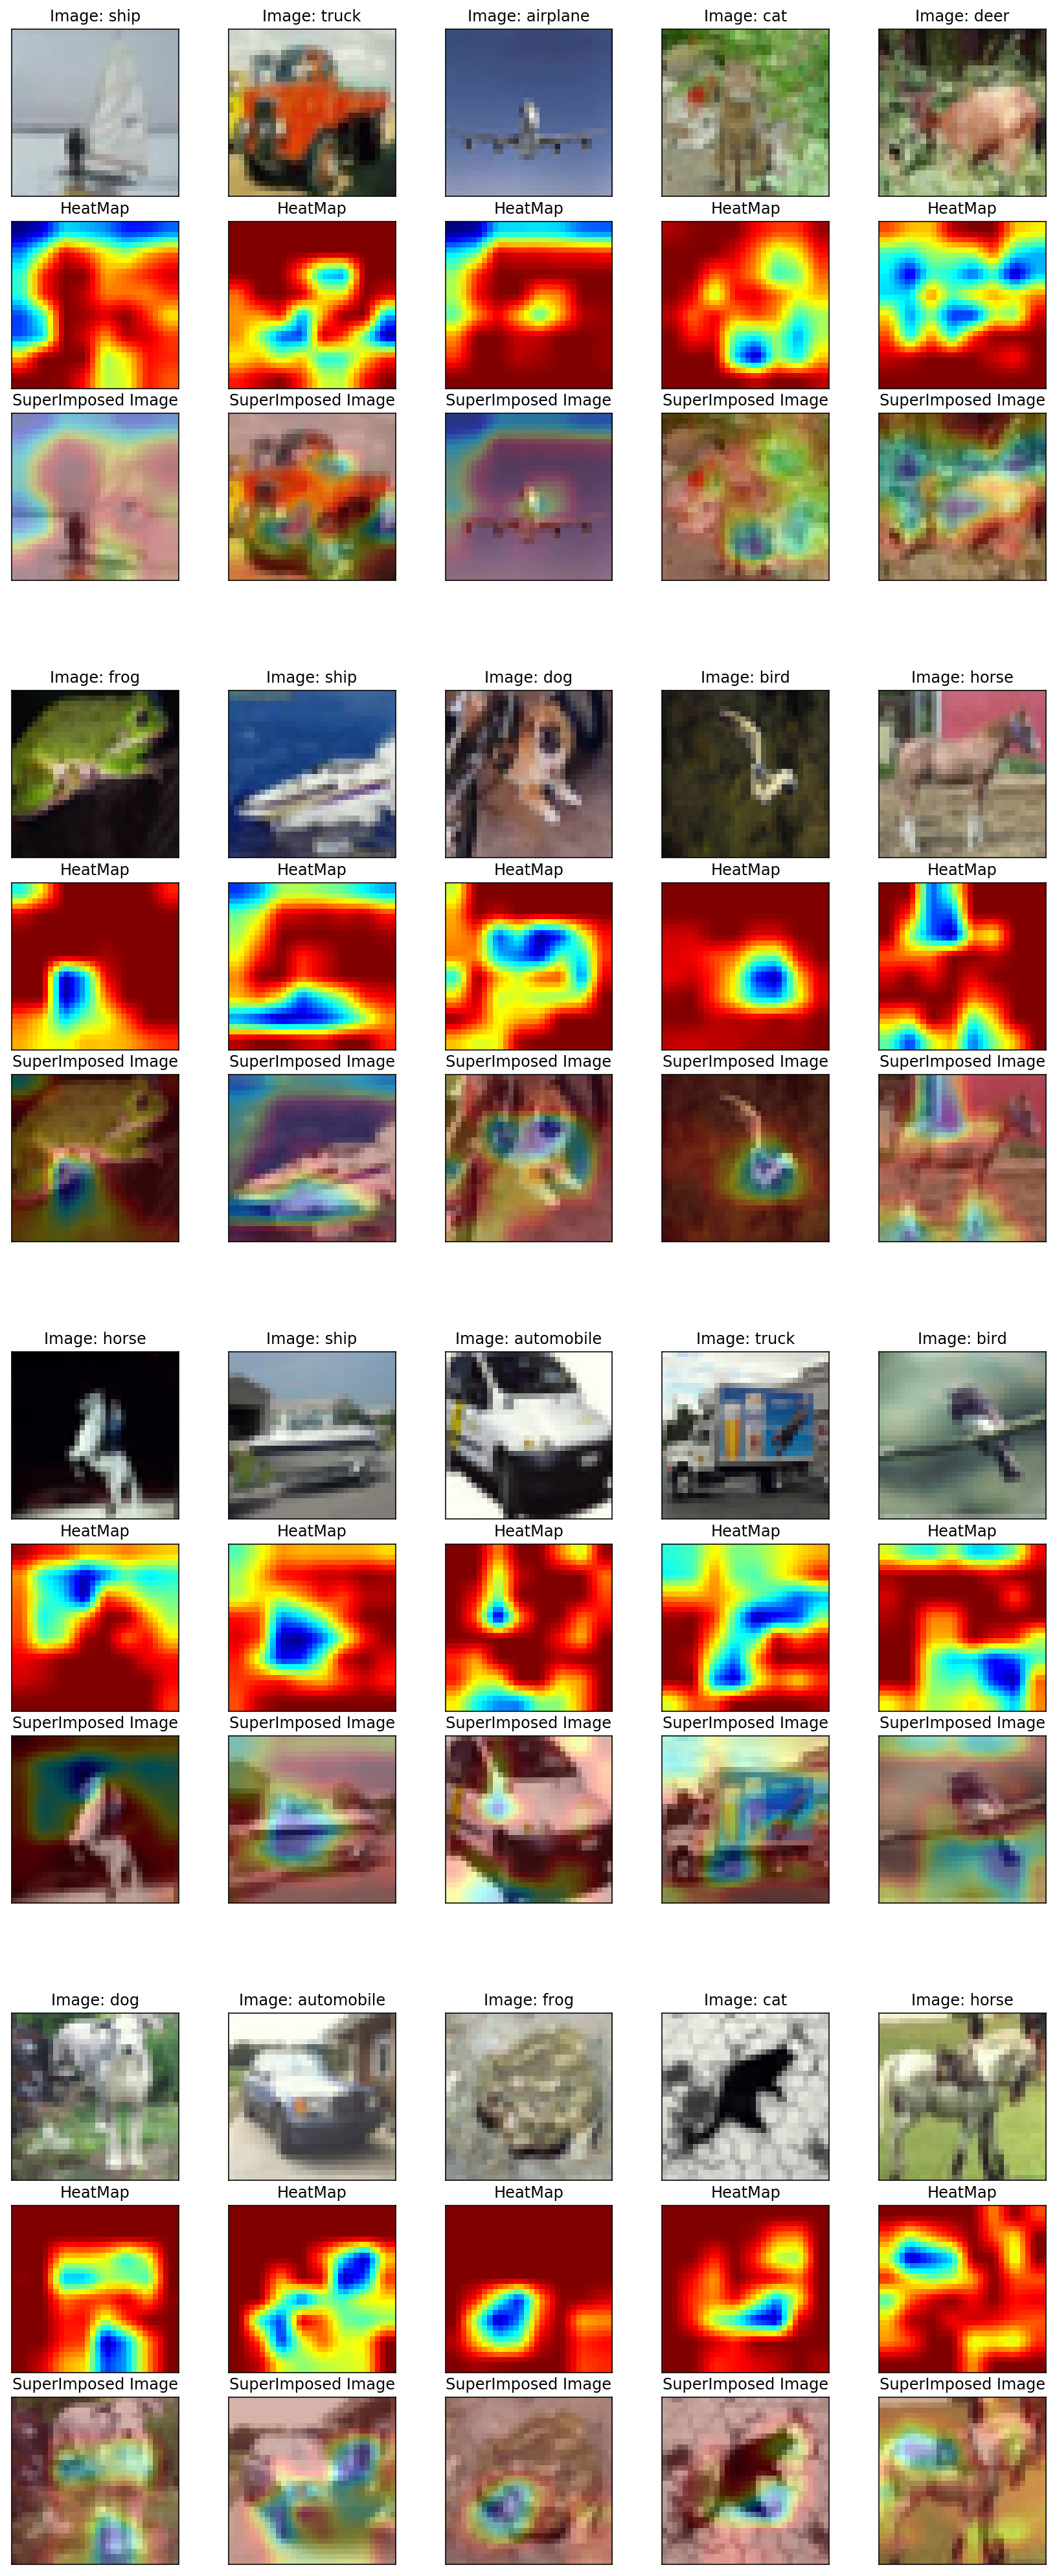

In [103]:

show_examples_with_gradcam(model,"output_transition",X_e[10:30], Y_e[10:30],classes,image_size_multiplier=3)

# After Cutout 

In [104]:
gc.collect()

70643

In [105]:
model = build_model()

(None, 16, 16, 624)
(None, 16, 16, 752)
(None, 8, 8, 576)
(None, 8, 8, 720)
Model Params =  869342
Layer Names:  ['input_16', 'initial_conv_conv_', 'initial_conv_bn_', 'initial_conv_activation_', '2nd_conv_conv_', '2nd_conv_bn_', '2nd_conv_activation_', '3nd_conv_conv_', '3nd_conv_bn_', '3nd_conv_activation_', 'spatial_dropout2d_16', '1_dilated_conv_conv_', '1_dilated_conv_bn_', '1_dilated_conv_activation_', 'concatenate_451', 'dense_1_tran_1', 'batch_normalization_120', 'activation_150', 'lambda_585', 'lambda_586', 'dense_1_layer_0group_0_sep-conv_sep-conv_', 'dense_1_layer_0group_1_conv_conv_', 'dense_1_layer_0group_0_sep-conv_bn_', 'dense_1_layer_0group_1_conv_bn_', 'dense_1_layer_0group_0_sep-conv_activation_', 'dense_1_layer_0group_1_conv_activation_', 'concatenate_452', 'lambda_587', 'concatenate_453', 'lambda_588', 'lambda_589', 'dense_1_layer_1group_0_sep-conv_sep-conv_', 'dense_1_layer_1group_1_conv_conv_', 'dense_1_layer_1group_0_sep-conv_bn_', 'dense_1_layer_1group_1_conv_bn

In [113]:

X_train, Y_train, X_test, Y_test = get_cifar10_data(preprocess=False)
datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,
                             preprocessing_function=get_cutout_eraser(p=0.75, s_l=0.05, s_h=0.2, r_1=0.3, r_2=1 / 0.3, max_erasures_per_image=3, pixel_level=True))
# datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True)

datagen_validation = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,)
datagen.fit(X_train)
datagen_validation.fit(X_train)

train_iterator = datagen.flow(X_train, Y_train, batch_size=256,shuffle=True)
validation_iterator = datagen_validation.flow(X_test, Y_test, batch_size=512,shuffle=True)

checkpoint = ModelCheckpoint("model-m5-50.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')

# clr = CyclicLR(base_lr=0.0001, max_lr=0.005,step_size=800, mode='triangular2')
lr_manager = OneCycleLR(samples=X_train.shape[0], epochs=20, batch_size=256,
                        steps=len(train_iterator), max_lr=0.0001,
                        end_percentage=0.1, scale_percentage=None,
                        maximum_momentum=None, minimum_momentum=None)

callbacks_list = [checkpoint,lr_manager]
train_history = model.fit_generator(train_iterator,
                    steps_per_epoch=len(train_iterator), 
                    validation_data = validation_iterator, 
                    validation_steps = len(validation_iterator),
                    epochs=20, verbose=2,
                    callbacks=callbacks_list,)



model.load_weights("model-m5-50.hdf5")


iterator = datagen_validation.flow(X_train, Y_train, batch_size=256, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen_validation.flow(X_train, Y_train, batch_size=256, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = inspect_predictions(score, predictions,Y_train, classes=get_cifar10_labels(),print_results=True, plot_results=False)


iterator = datagen_validation.flow(X_test, Y_test, batch_size=256, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen_validation.flow(X_test, Y_test, batch_size=256, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = inspect_predictions(score, predictions,Y_test, classes=get_cifar10_labels(),print_results=True, plot_results=False)

Epoch 1/20
 - 87s - loss: 0.3273 - acc: 0.9391 - val_loss: 0.4668 - val_acc: 0.9090
 - lr: 0.00002 
Epoch 2/20
 - 87s - loss: 0.3249 - acc: 0.9410 - val_loss: 0.4693 - val_acc: 0.9088
 - lr: 0.00003 
Epoch 3/20
 - 87s - loss: 0.3244 - acc: 0.9418 - val_loss: 0.4681 - val_acc: 0.9085
 - lr: 0.00004 
Epoch 4/20
 - 87s - loss: 0.3216 - acc: 0.9406 - val_loss: 0.4741 - val_acc: 0.9072
 - lr: 0.00005 
Epoch 5/20
 - 87s - loss: 0.3178 - acc: 0.9430 - val_loss: 0.4742 - val_acc: 0.9066
 - lr: 0.00006 
Epoch 6/20
 - 86s - loss: 0.3277 - acc: 0.9374 - val_loss: 0.4797 - val_acc: 0.9067
 - lr: 0.00007 
Epoch 7/20
 - 87s - loss: 0.3179 - acc: 0.9422 - val_loss: 0.4724 - val_acc: 0.9079
 - lr: 0.00008 
Epoch 8/20
 - 87s - loss: 0.3178 - acc: 0.9429 - val_loss: 0.4906 - val_acc: 0.9059
 - lr: 0.00009 
Epoch 9/20
 - 87s - loss: 0.3175 - acc: 0.9418 - val_loss: 0.4833 - val_acc: 0.9067
 - lr: 0.00010 
Epoch 10/20
 - 87s - loss: 0.3130 - acc: 0.9438 - val_loss: 0.4930 - val_acc: 0.9057
 - lr: 0.00009 

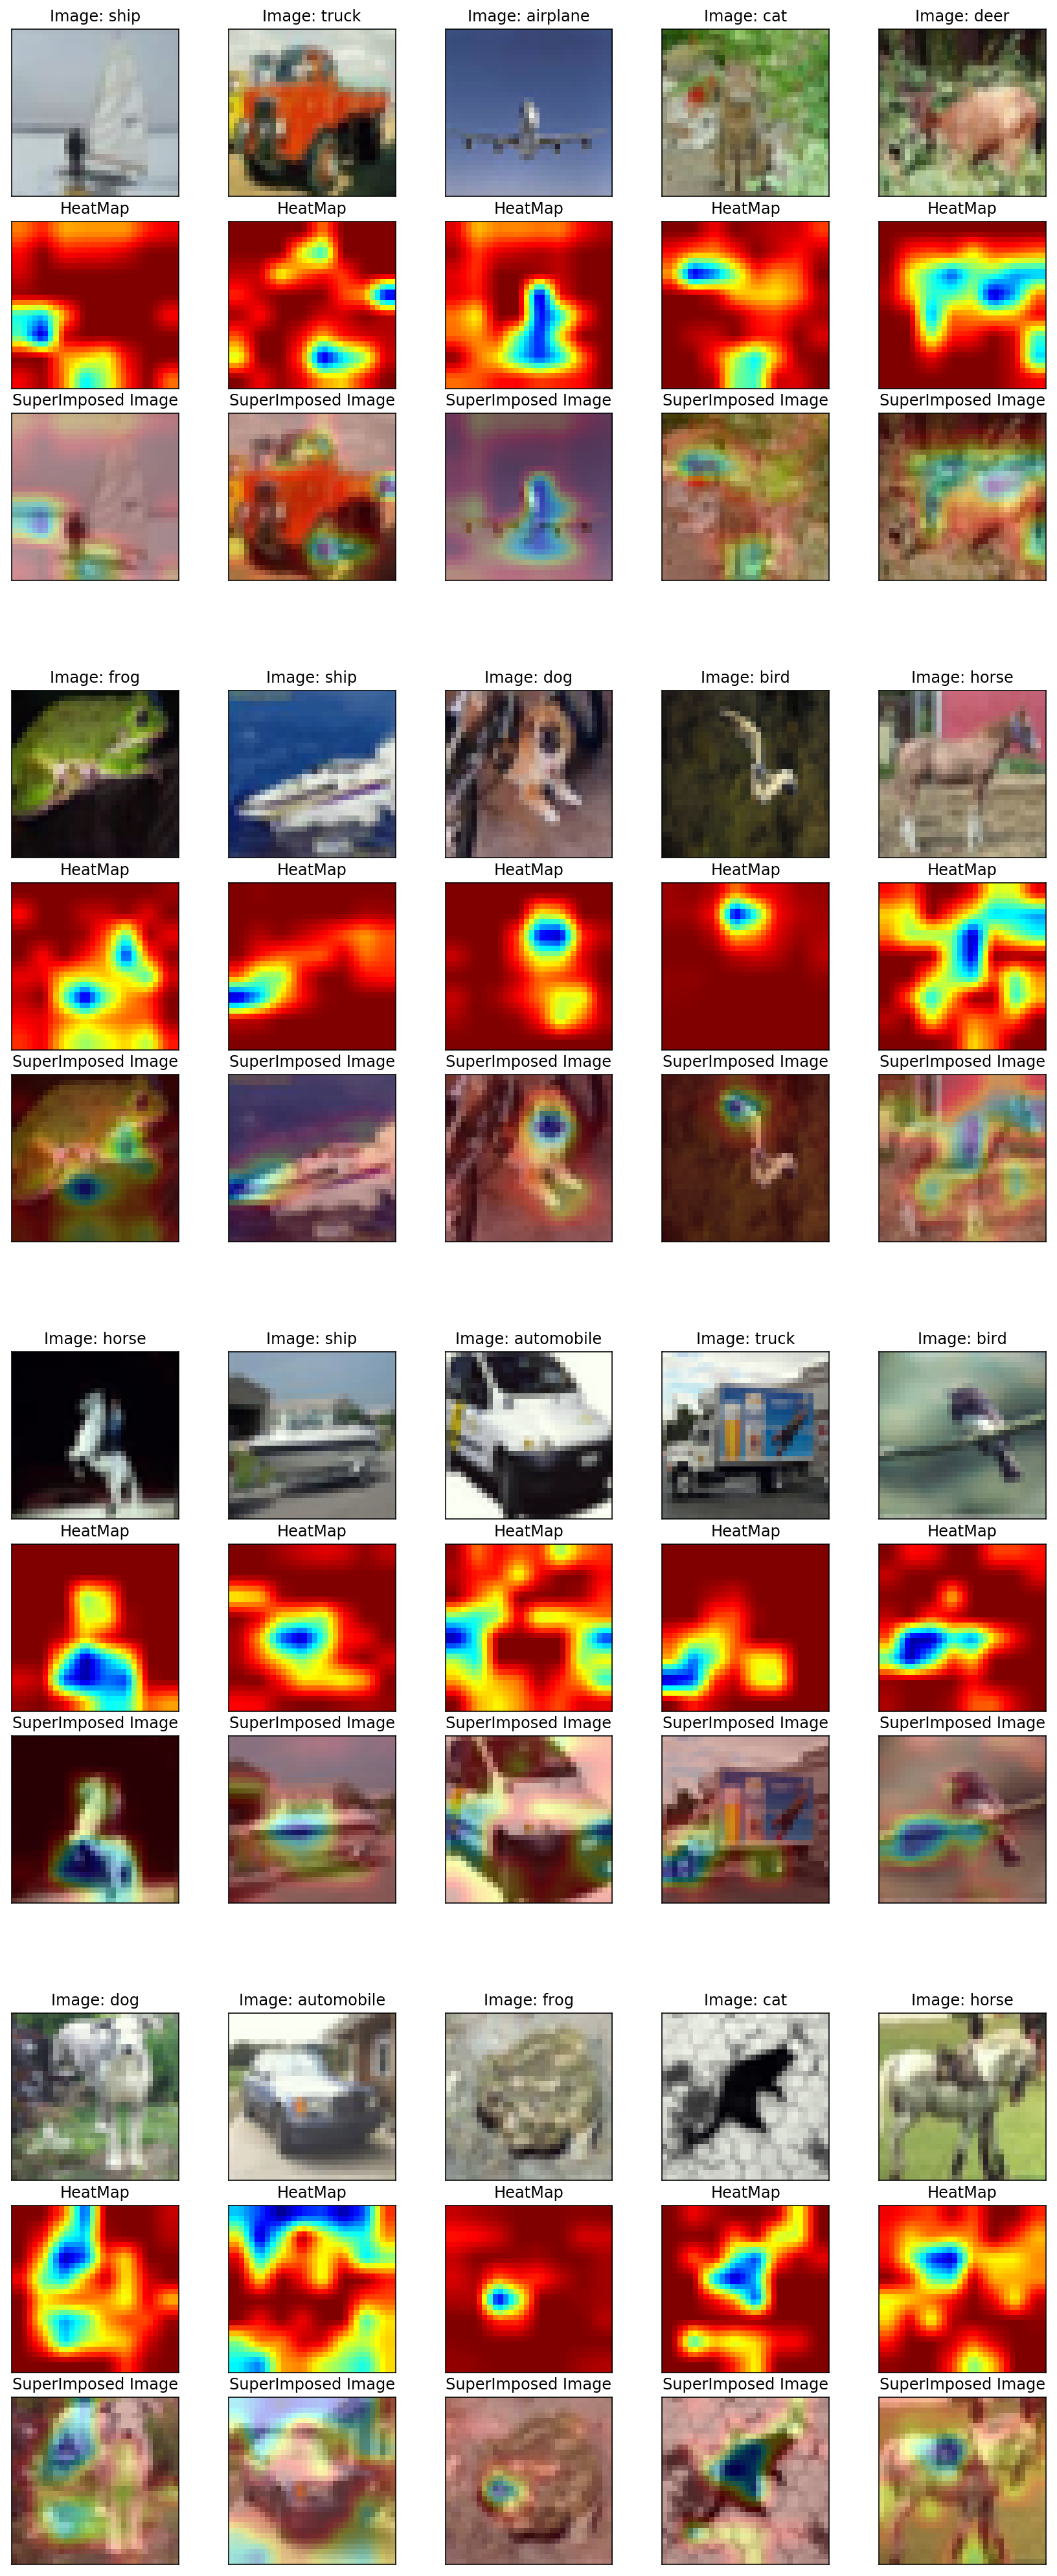

In [114]:
show_examples_with_gradcam(model,"output_transition",X_e[10:30], Y_e[10:30],classes,image_size_multiplier=3)

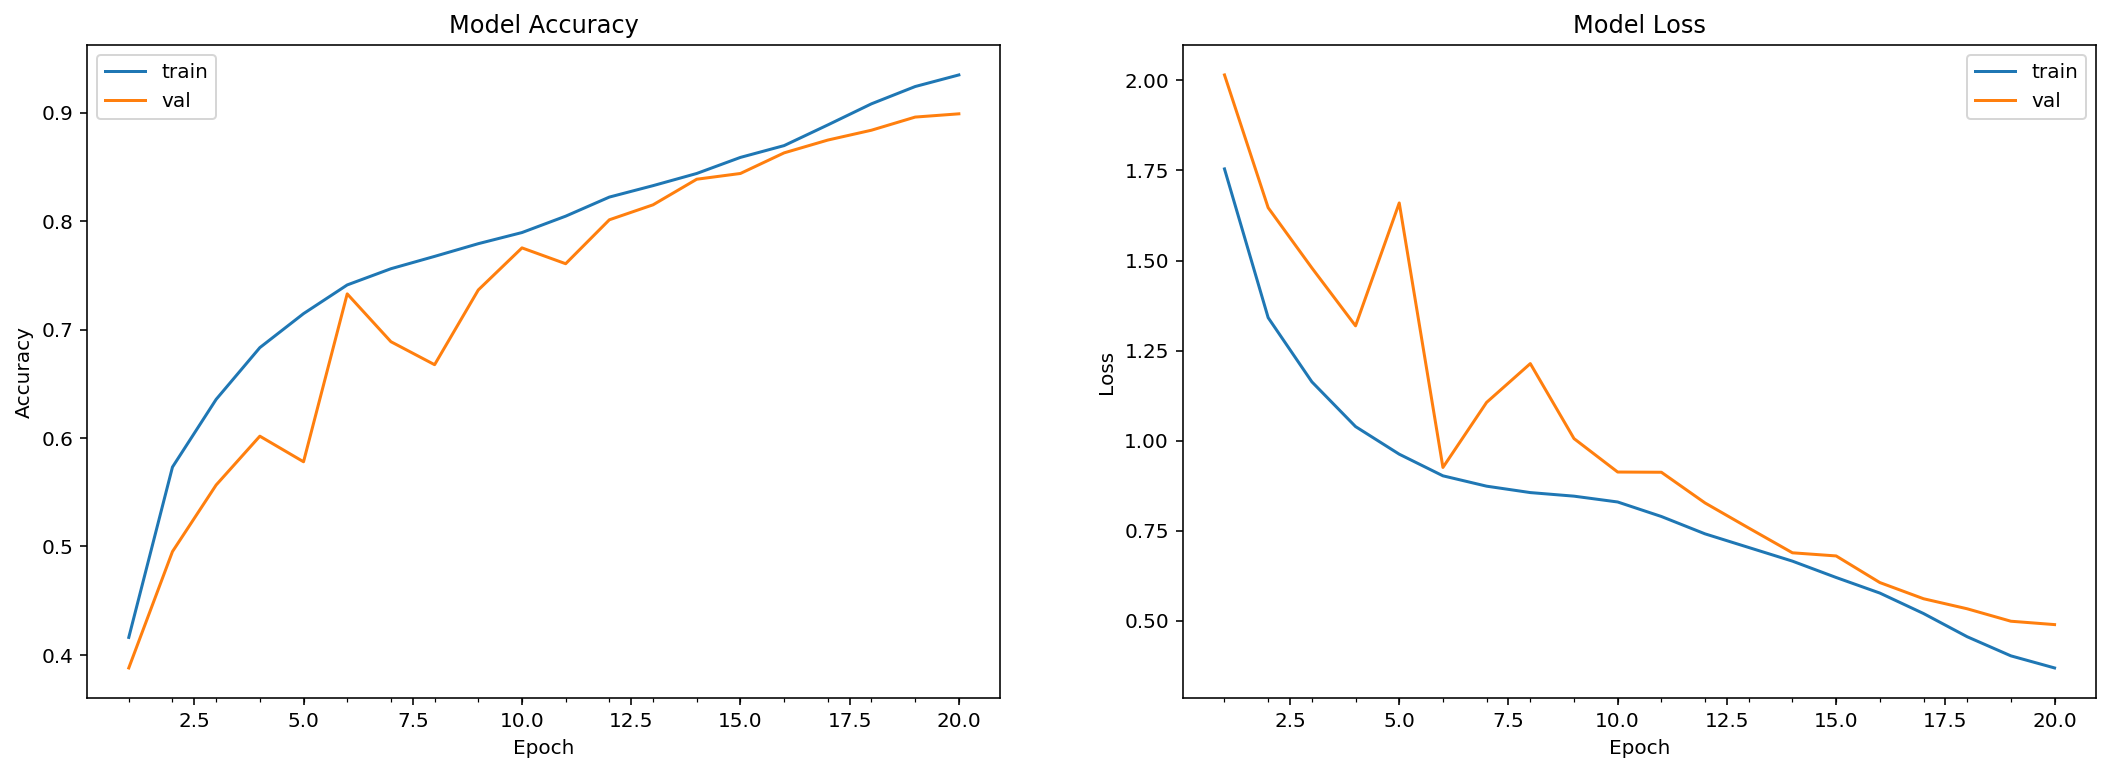

In [108]:
plot_model_history(train_history)

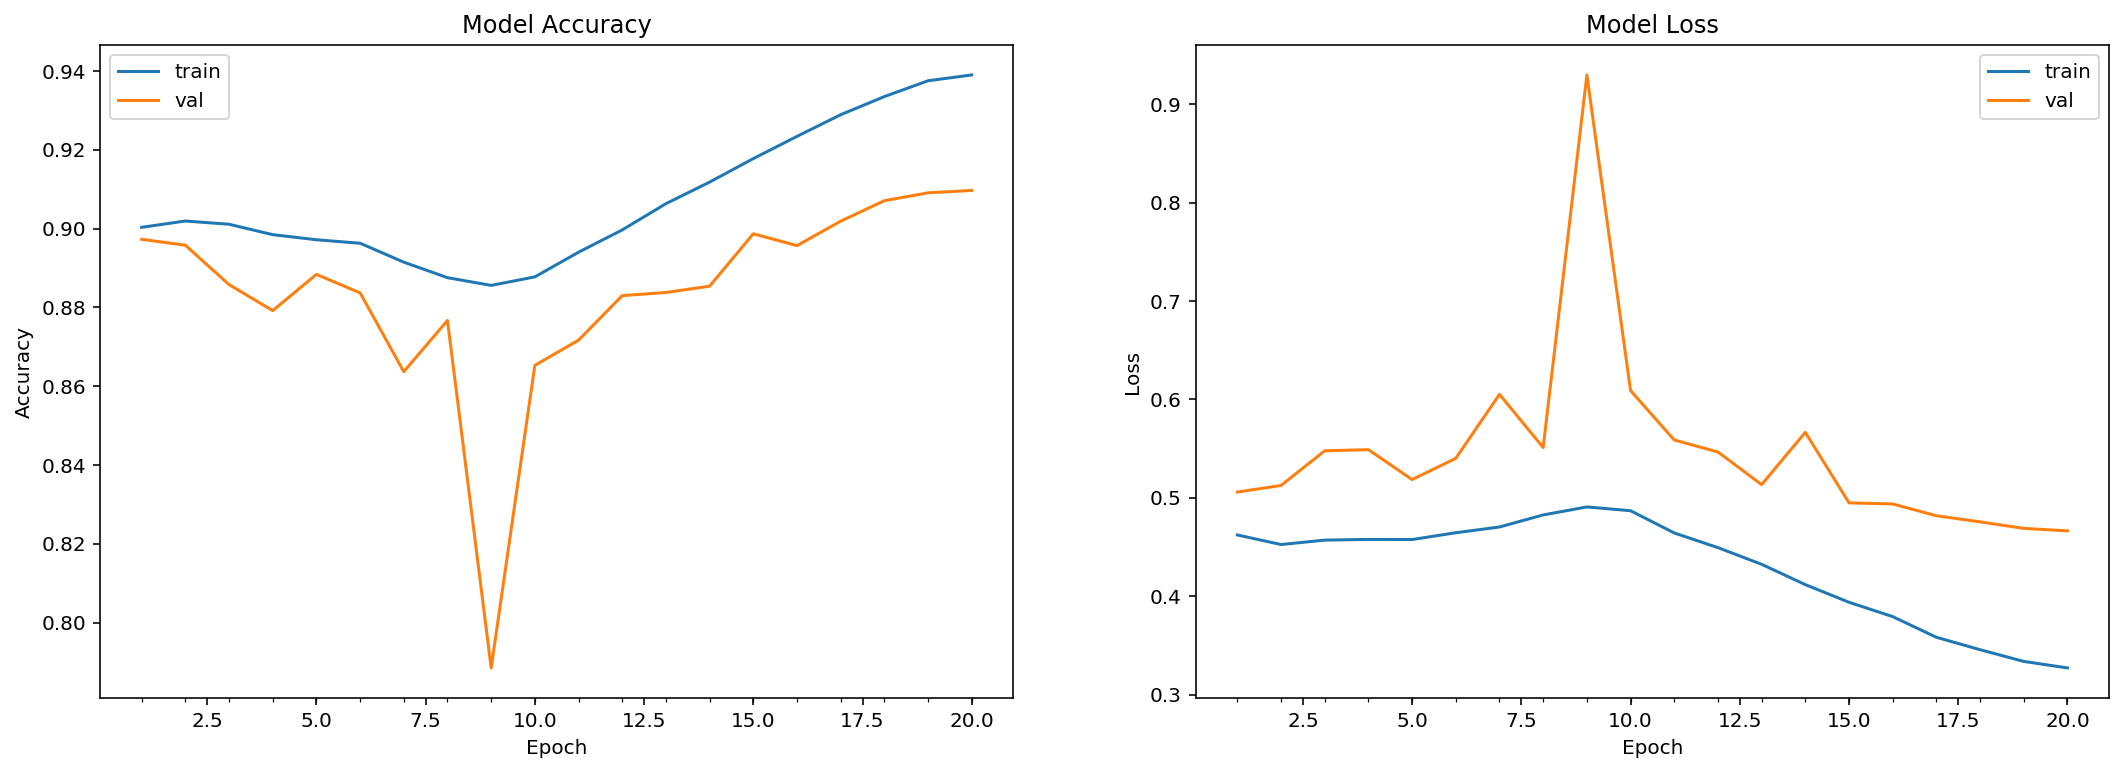

In [111]:
plot_model_history(train_history)

# RICAP

In [53]:
!wget https://raw.githubusercontent.com/koshian2/keras-ricap/master/ricap.py

--2019-07-03 10:11:36--  https://raw.githubusercontent.com/koshian2/keras-ricap/master/ricap.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2884 (2.8K) [text/plain]
Saving to: ‘ricap.py’

ricap.py            100%[===================>]   2.82K  --.-KB/s    in 0s      

2019-07-03 10:11:36 (78.3 MB/s) - ‘ricap.py’ saved [2884/2884]



In [93]:
from keras.preprocessing.image import ImageDataGenerator
from ricap import ricap




        

# RICAP Generator
class RICAPGenerator(ImageDataGenerator):
    def __init__(self, batch_size,samples,ricap_proba=0.5,ricap_beta=10.0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.ricap_beta = ricap_beta
        self.ricap_proba = ricap_proba
        self.length = int(np.ceil(samples/batch_size))

    def gen_fn_flow(self, *args, **kwargs):
      for batch_X, batch_y in super().flow(*args, **kwargs):
          p_1 = np.random.rand()
          if p_1 > self.ricap_proba:
            yield batch_X, batch_y
          else:
            rb = np.random.rand()*self.ricap_beta
            ricap_X, ricap_y = ricap(batch_X, batch_y, rb)
            yield ricap_X, ricap_y
      
    def flow(self, *args, **kwargs):
      return MakeIter(self.gen_fn_flow,self.length, *args, **kwargs)
            
    def __len__(self): 
        return self.length
      
print()

# print(Y_e[0:10])


In [66]:
gc.collect()
print()
model = build_model()

395


(None, 16, 16, 624)
(None, 16, 16, 752)
(None, 8, 8, 576)
(None, 8, 8, 720)
Model Params =  869342
Layer Names:  ['input_14', 'initial_conv_conv_', 'initial_conv_bn_', 'initial_conv_activation_', '2nd_conv_conv_', '2nd_conv_bn_', '2nd_conv_activation_', '3nd_conv_conv_', '3nd_conv_bn_', '3nd_conv_activation_', 'spatial_dropout2d_14', '1_dilated_conv_conv_', '1_dilated_conv_bn_', '1_dilated_conv_activation_', 'concatenate_391', 'dense_1_tran_1', 'batch_normalization_102', 'activation_128', 'lambda_507', 'lambda_508', 'dense_1_layer_0group_0_sep-conv_sep-conv_', 'dense_1_layer_0group_1_conv_conv_', 'dense_1_layer_0group_0_sep-conv_bn_', 'dense_1_layer_0group_1_conv_bn_', 'dense_1_layer_0group_0_sep-conv_activation_', 'dense_1_layer_0group_1_conv_activation_', 'concatenate_392', 'lambda_509', 'concatenate_393', 'lambda_510', 'lambda_511', 'dense_1_layer_1group_0_sep-conv_sep-conv_', 'dense_1_layer_1group_1_conv_conv_', 'dense_1_layer_1group_0_sep-conv_bn_', 'dense_1_layer_1group_1_conv_b

In [96]:
gc.collect()

0

In [99]:

X_train, Y_train, X_test, Y_test = get_cifar10_data(preprocess=False)
datagen = RICAPGenerator(batch_size=256,samples=X_train.shape[0],ricap_proba=0.25,featurewise_center=True,featurewise_std_normalization=True,)
# datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True)

datagen_validation = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,)
datagen.fit(X_train)
datagen_validation.fit(X_train)

train_iterator = datagen.flow(X_train, Y_train, batch_size=256,shuffle=True)
validation_iterator = datagen_validation.flow(X_test, Y_test, batch_size=512,shuffle=True)

checkpoint = ModelCheckpoint("model-m5-50.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')

# clr = CyclicLR(base_lr=0.0001, max_lr=0.005,step_size=800, mode='triangular2')
lr_manager = OneCycleLR(samples=X_train.shape[0], epochs=10, batch_size=256,
                        steps=len(train_iterator), max_lr=0.0005,
                        end_percentage=0.1, scale_percentage=None,
                        maximum_momentum=None, minimum_momentum=None)

callbacks_list = [checkpoint,lr_manager]
train_history = model.fit_generator(train_iterator,
                    steps_per_epoch=len(train_iterator), 
                    validation_data = validation_iterator, 
                    validation_steps = len(validation_iterator),
                    epochs=10, verbose=2,
                    callbacks=callbacks_list,)



model.load_weights("model-m5-50.hdf5")


iterator = datagen_validation.flow(X_train, Y_train, batch_size=512, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen_validation.flow(X_train, Y_train, batch_size=512, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = inspect_predictions(score, predictions,Y_train, classes=get_cifar10_labels(),print_results=True, plot_results=False)


iterator = datagen_validation.flow(X_test, Y_test, batch_size=512, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen_validation.flow(X_test, Y_test, batch_size=512, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = inspect_predictions(score, predictions,Y_test, classes=get_cifar10_labels(),print_results=True, plot_results=False)

Epoch 1/10
 - 87s - loss: 0.6164 - acc: 0.8716 - val_loss: 0.4360 - val_acc: 0.8882
 - lr: 0.00015 
Epoch 2/10
 - 86s - loss: 0.6203 - acc: 0.8677 - val_loss: 0.4336 - val_acc: 0.8872
 - lr: 0.00025 
Epoch 3/10
 - 86s - loss: 0.5902 - acc: 0.8798 - val_loss: 0.4746 - val_acc: 0.8741
 - lr: 0.00035 
Epoch 4/10
 - 86s - loss: 0.6337 - acc: 0.8606 - val_loss: 0.5187 - val_acc: 0.8608
 - lr: 0.00045 
Epoch 5/10
 - 86s - loss: 0.5728 - acc: 0.8787 - val_loss: 0.4829 - val_acc: 0.8745
 - lr: 0.00045 
Epoch 6/10
 - 86s - loss: 0.6007 - acc: 0.8771 - val_loss: 0.4473 - val_acc: 0.8840
 - lr: 0.00035 
Epoch 7/10
 - 86s - loss: 0.5601 - acc: 0.8925 - val_loss: 0.4348 - val_acc: 0.8867
 - lr: 0.00025 
Epoch 8/10
 - 86s - loss: 0.5380 - acc: 0.8941 - val_loss: 0.4299 - val_acc: 0.8914
 - lr: 0.00015 
Epoch 9/10
 - 86s - loss: 0.5848 - acc: 0.8945 - val_loss: 0.4309 - val_acc: 0.8925
 - lr: 0.00005 
Epoch 10/10
 - 86s - loss: 0.5824 - acc: 0.8882 - val_loss: 0.4224 - val_acc: 0.8954
 - lr: 0.00000 

70419

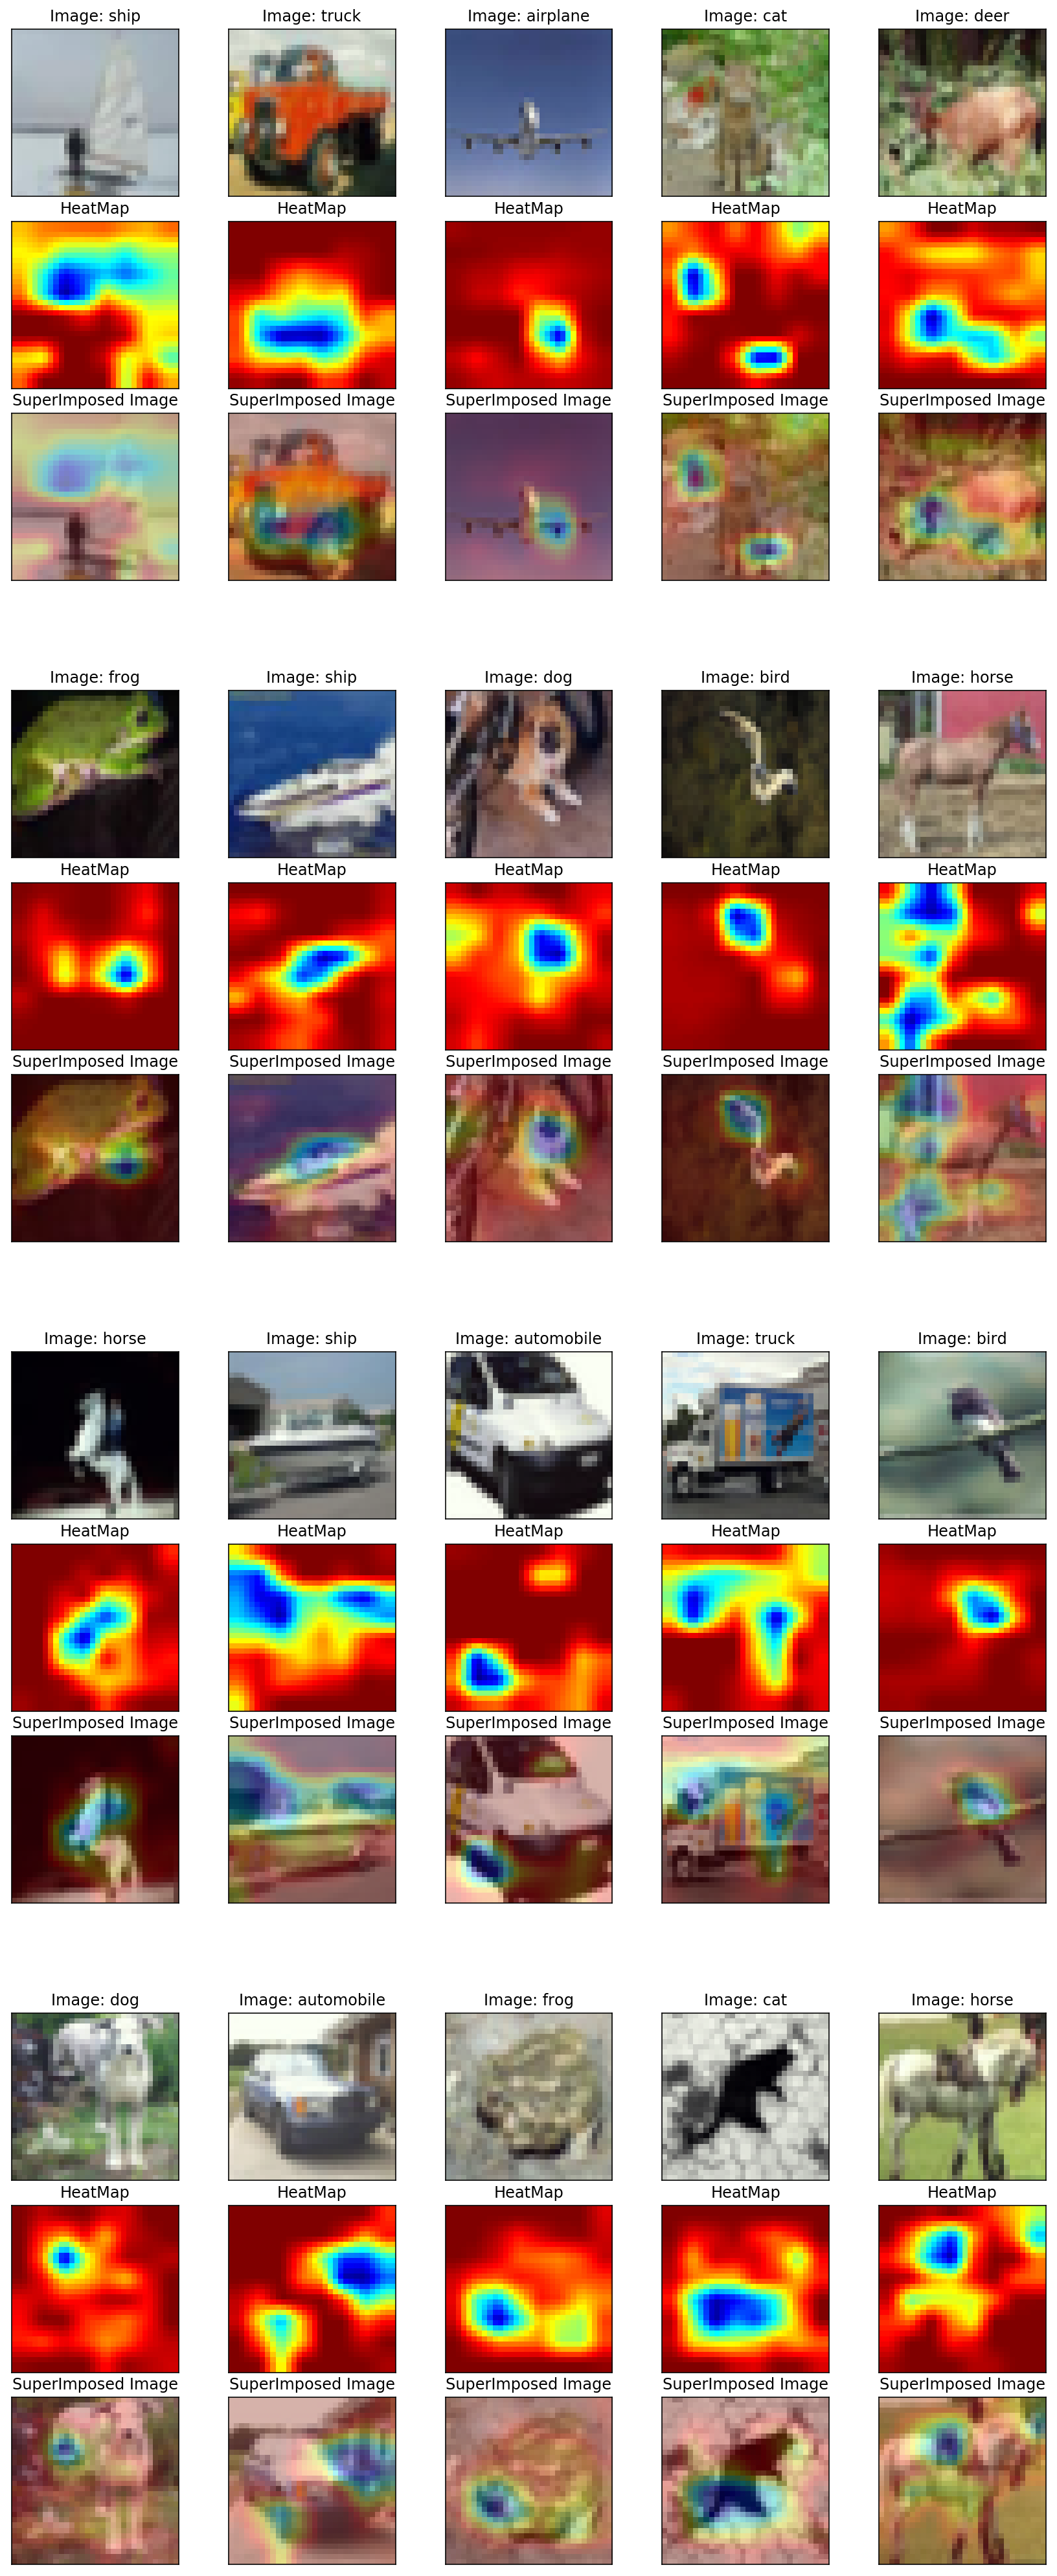

In [100]:
gc.collect()
show_examples_with_gradcam(model,"output_transition",X_e[10:30], Y_e[10:30],classes,image_size_multiplier=3)

In [81]:
gc.collect()

35874

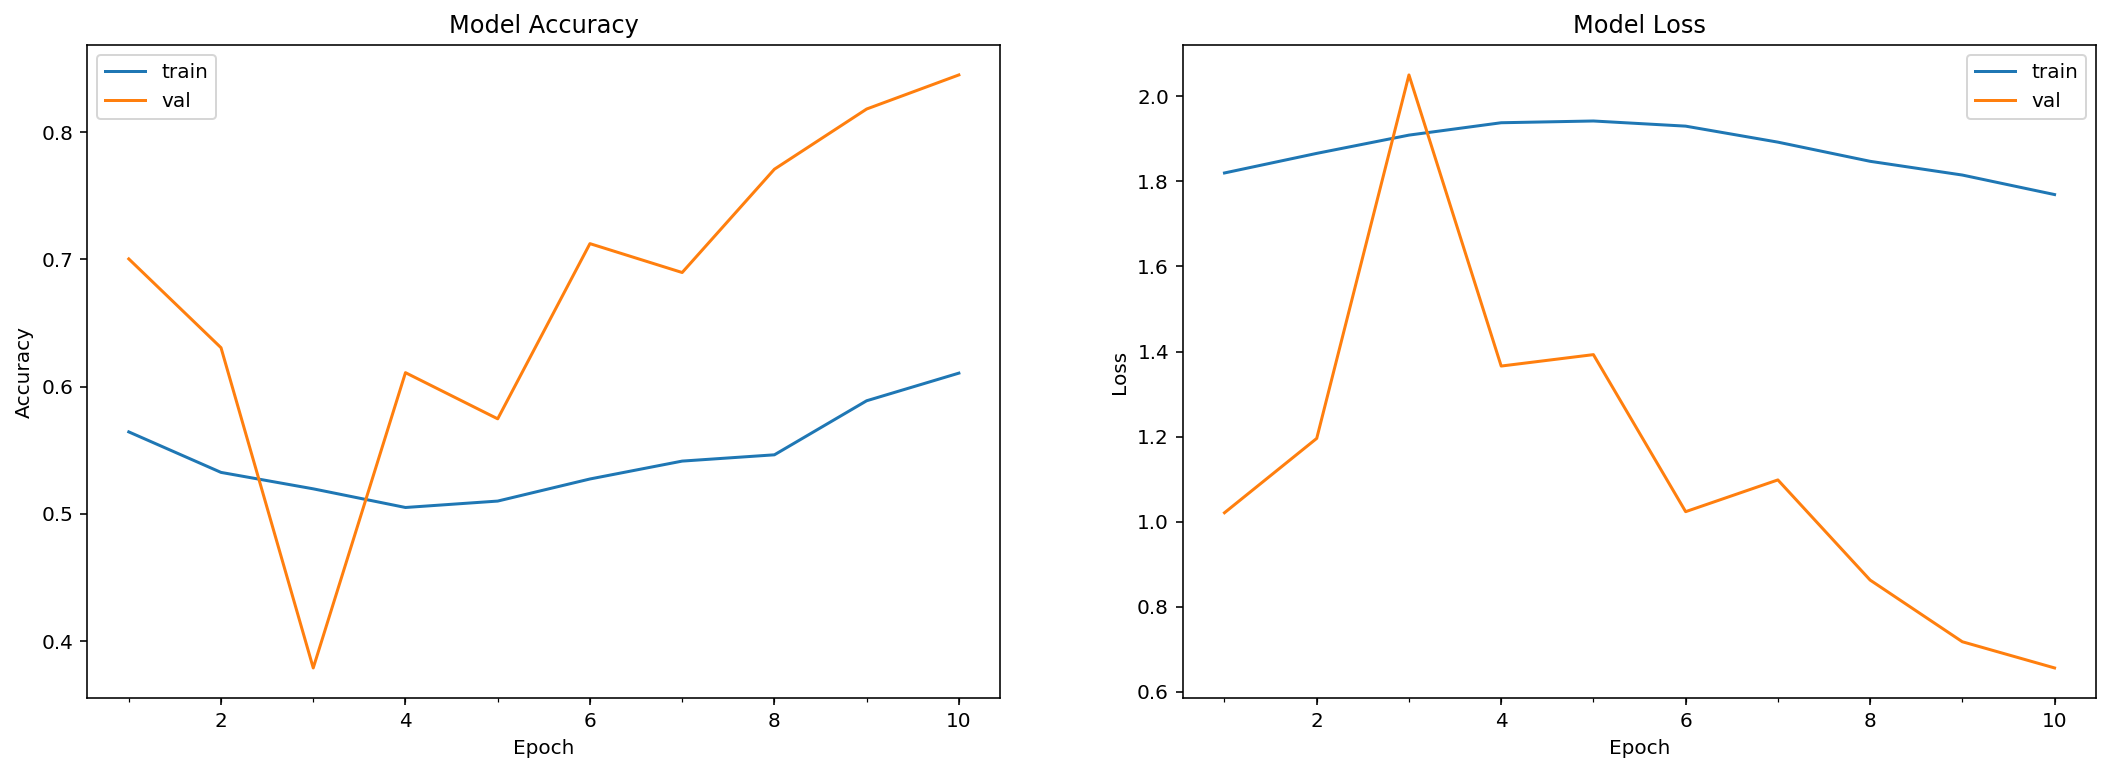

In [75]:
plot_model_history(train_history)

# RICAP + Cutout + Others

In [115]:
from ricap import ricap       

# RICAP Generator
class RicapCutoutGenerator(ImageDataGenerator):
    def __init__(self, batch_size,samples,
                 ricap_proba=0.25,ricap_beta=10.0,
                 cutout_proba=0.25, max_num_cutouts=2,
                 *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.ricap_beta = ricap_beta
        self.ricap_proba = ricap_proba
        self.length = int(np.ceil(samples/batch_size))
        self.cutout_proba = cutout_proba
        self.max_num_cutouts = max_num_cutouts
        self.eraser = get_cutout_eraser(p=1.0, s_l=0.05, s_h=0.2, r_1=0.3, r_2=1 / 0.3, max_erasures_per_image=max_num_cutouts, pixel_level=True)

    def gen_fn_flow(self, *args, **kwargs):
      for batch_X, batch_y in super().flow(*args, **kwargs):
          p_1 = np.random.rand()
          if p_1<=self.ricap_proba:
            rb = np.random.rand()*self.ricap_beta
            ricap_X, ricap_y = ricap(batch_X, batch_y, rb)
            yield ricap_X, ricap_y
          elif p_1 <= self.ricap_proba+self.cutout_proba:
            for i,x in enumerate(batch_X):
              batch_X[i] = self.eraser(x)
            yield batch_X, batch_y
          else:
            yield batch_X, batch_y
      
    def flow(self, *args, **kwargs):
      return MakeIter(self.gen_fn_flow,self.length, *args, **kwargs)
            
    def __len__(self): 
        return self.length
      
print()

In [117]:
gc.collect()
print()
model = build_model()

321593


(None, 16, 16, 624)
(None, 16, 16, 752)
(None, 8, 8, 576)
(None, 8, 8, 720)
Model Params =  869342
Layer Names:  ['input_17', 'initial_conv_conv_', 'initial_conv_bn_', 'initial_conv_activation_', '2nd_conv_conv_', '2nd_conv_bn_', '2nd_conv_activation_', '3nd_conv_conv_', '3nd_conv_bn_', '3nd_conv_activation_', 'spatial_dropout2d_17', '1_dilated_conv_conv_', '1_dilated_conv_bn_', '1_dilated_conv_activation_', 'concatenate_481', 'dense_1_tran_1', 'batch_normalization_129', 'activation_161', 'lambda_624', 'lambda_625', 'dense_1_layer_0group_0_sep-conv_sep-conv_', 'dense_1_layer_0group_1_conv_conv_', 'dense_1_layer_0group_0_sep-conv_bn_', 'dense_1_layer_0group_1_conv_bn_', 'dense_1_layer_0group_0_sep-conv_activation_', 'dense_1_layer_0group_1_conv_activation_', 'concatenate_482', 'lambda_626', 'concatenate_483', 'lambda_627', 'lambda_628', 'dense_1_layer_1group_0_sep-conv_sep-conv_', 'dense_1_layer_1group_1_conv_conv_', 'dense_1_layer_1group_0_sep-conv_bn_', 'dense_1_layer_1group_1_conv_b

In [118]:

X_train, Y_train, X_test, Y_test = get_cifar10_data(preprocess=False)
datagen = RicapCutoutGenerator(batch_size=256,samples=X_train.shape[0],
                               featurewise_center=True,featurewise_std_normalization=True,
                              horizontal_flip=True,channel_shift_range=0.1,zoom_range=0.1, height_shift_range=0.1,width_shift_range=0.1,rotation_range=10, )


datagen_validation = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,)
datagen.fit(X_train)
datagen_validation.fit(X_train)

train_iterator = datagen.flow(X_train, Y_train, batch_size=256,shuffle=True)
validation_iterator = datagen_validation.flow(X_test, Y_test, batch_size=512,shuffle=True)

checkpoint = ModelCheckpoint("model-m5-50.hdf5", monitor='val_acc', verbose=0, save_best_only=True, mode='max')

# clr = CyclicLR(base_lr=0.0001, max_lr=0.005,step_size=800, mode='triangular2')
lr_manager = OneCycleLR(samples=X_train.shape[0], epochs=50, batch_size=256,
                        steps=len(train_iterator), max_lr=0.005,
                        end_percentage=0.1, scale_percentage=None,
                        maximum_momentum=None, minimum_momentum=None)

callbacks_list = [checkpoint,lr_manager]
train_history = model.fit_generator(train_iterator,
                    steps_per_epoch=len(train_iterator), 
                    validation_data = validation_iterator, 
                    validation_steps = len(validation_iterator),
                    epochs=50, verbose=2,
                    callbacks=callbacks_list,)



model.load_weights("model-m5-50.hdf5")


iterator = datagen_validation.flow(X_train, Y_train, batch_size=512, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen_validation.flow(X_train, Y_train, batch_size=512, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = inspect_predictions(score, predictions,Y_train, classes=get_cifar10_labels(),print_results=True, plot_results=False)


iterator = datagen_validation.flow(X_test, Y_test, batch_size=512, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen_validation.flow(X_test, Y_test, batch_size=512, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = inspect_predictions(score, predictions,Y_test, classes=get_cifar10_labels(),print_results=True, plot_results=False)

Epoch 1/50


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.197999). Check your callbacks.
  % delta_t_median)


 - 102s - loss: 1.9532 - acc: 0.3597 - val_loss: 2.1120 - val_acc: 0.4048
 - lr: 0.00070 
Epoch 2/50
 - 88s - loss: 1.7280 - acc: 0.4603 - val_loss: 1.7202 - val_acc: 0.4853
 - lr: 0.00090 
Epoch 3/50
 - 88s - loss: 1.6031 - acc: 0.5113 - val_loss: 1.4250 - val_acc: 0.5386
 - lr: 0.00110 
Epoch 4/50
 - 88s - loss: 1.4850 - acc: 0.5482 - val_loss: 1.1415 - val_acc: 0.6443
 - lr: 0.00130 
Epoch 5/50
 - 87s - loss: 1.4149 - acc: 0.5730 - val_loss: 1.1219 - val_acc: 0.6649
 - lr: 0.00150 
Epoch 6/50
 - 87s - loss: 1.3412 - acc: 0.5977 - val_loss: 1.1470 - val_acc: 0.6428
 - lr: 0.00170 
Epoch 7/50
 - 87s - loss: 1.3551 - acc: 0.6038 - val_loss: 1.2398 - val_acc: 0.6228
 - lr: 0.00190 
Epoch 8/50
 - 87s - loss: 1.2444 - acc: 0.6358 - val_loss: 1.1620 - val_acc: 0.6688
 - lr: 0.00210 
Epoch 9/50
 - 87s - loss: 1.2451 - acc: 0.6431 - val_loss: 1.0066 - val_acc: 0.7221
 - lr: 0.00230 
Epoch 10/50
 - 87s - loss: 1.1555 - acc: 0.6680 - val_loss: 1.1428 - val_acc: 0.6580
 - lr: 0.00250 
Epoch 11/

In [0]:
datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,)
_ = datagen.fit(X_train)
train_iterator = datagen.flow(X_test, Y_test, batch_size=100,shuffle=False)

X_e, Y_e = train_iterator.next()
X_e = min_max_scale(X_e)


429

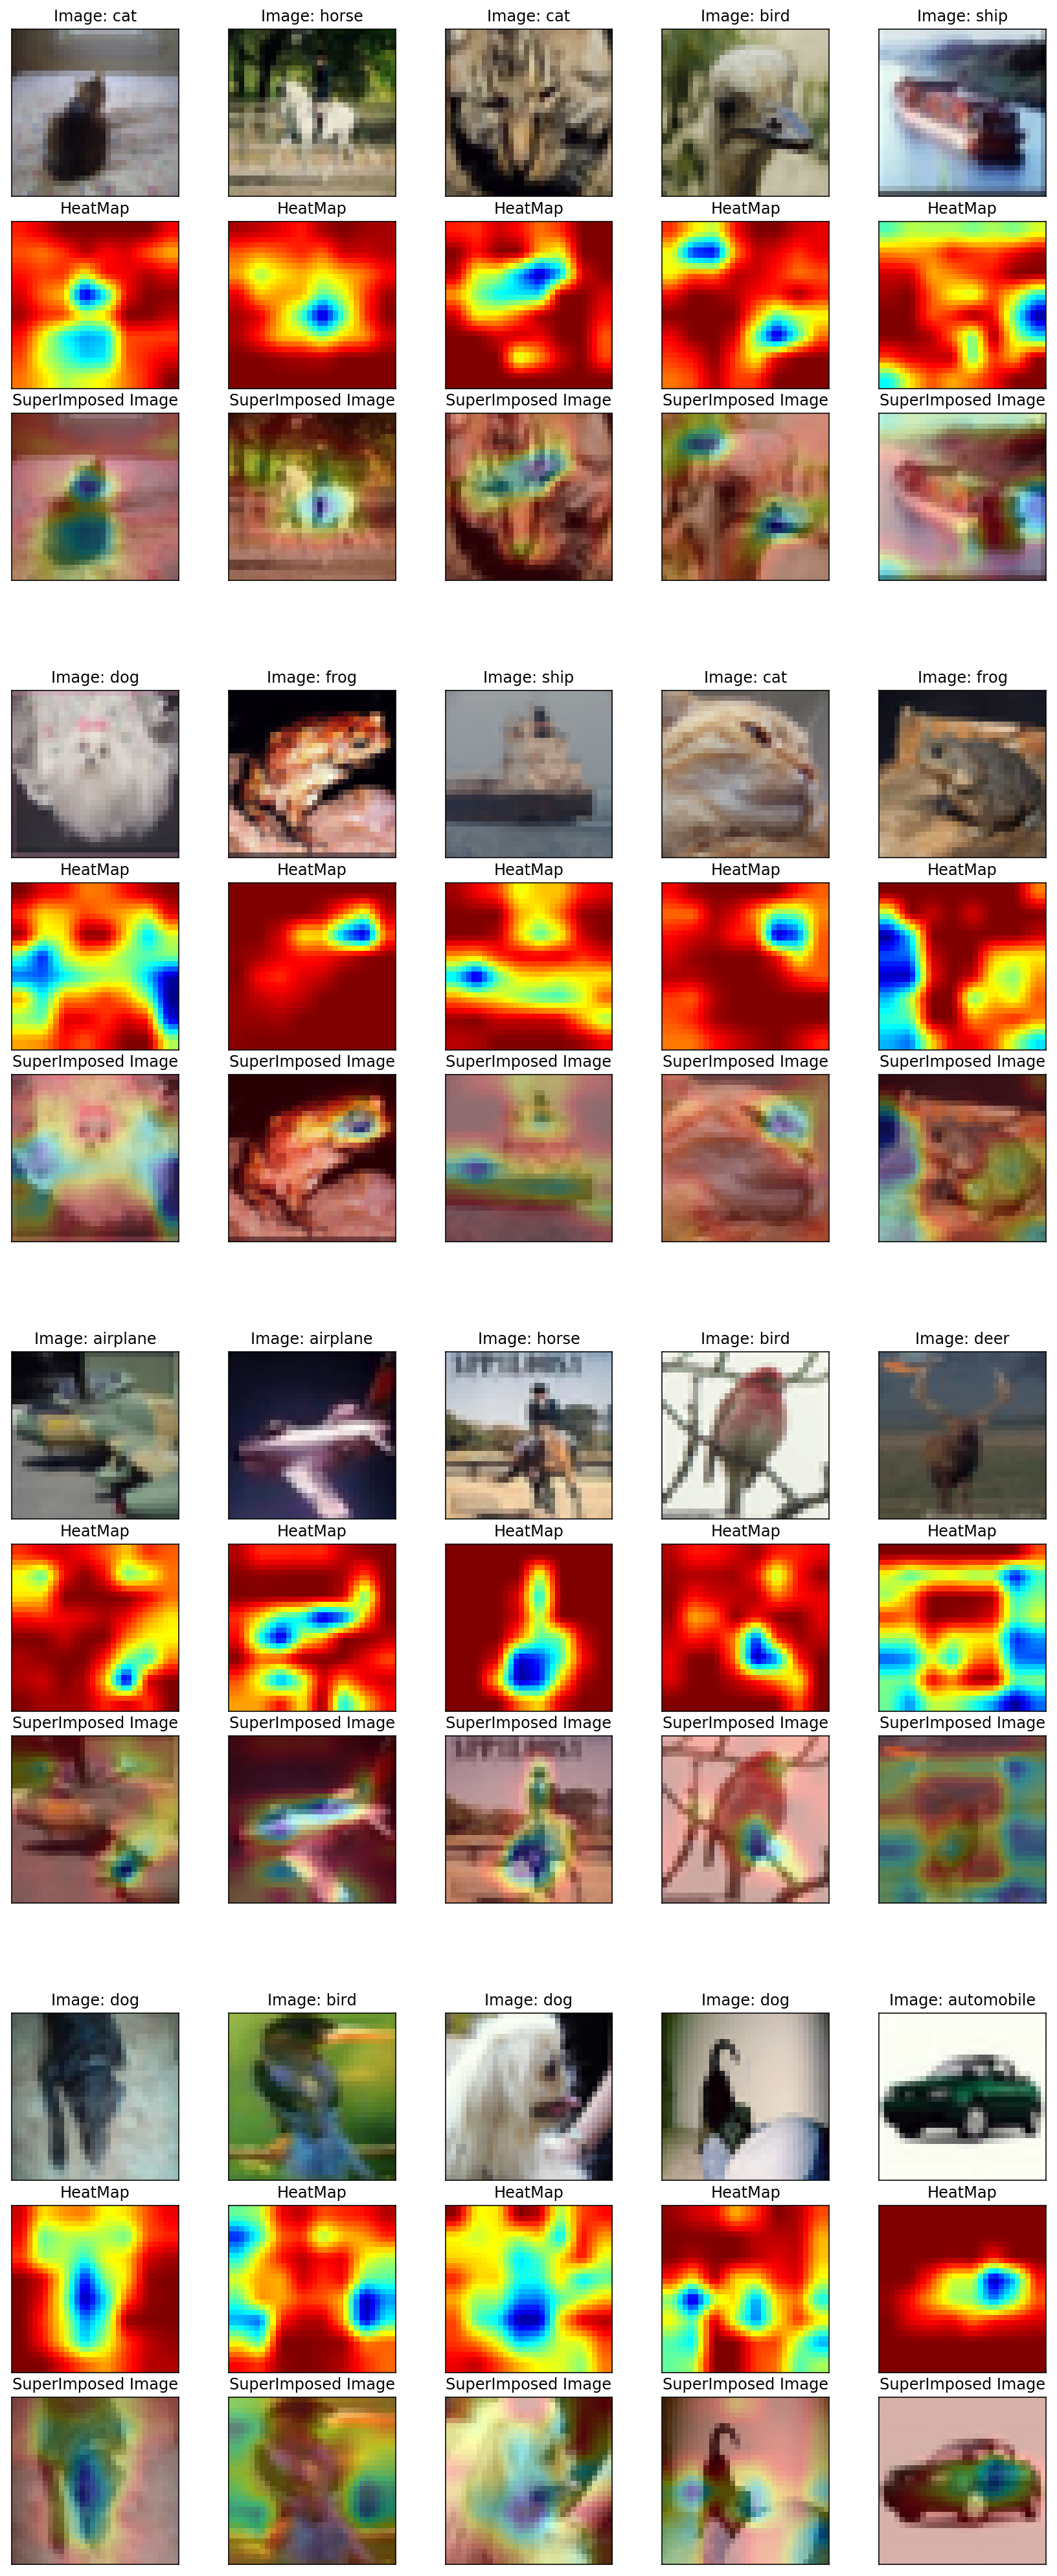

In [120]:
gc.collect()
show_examples_with_gradcam(model,"output_transition",X_e[10:30], Y_e[10:30],classes,image_size_multiplier=3)

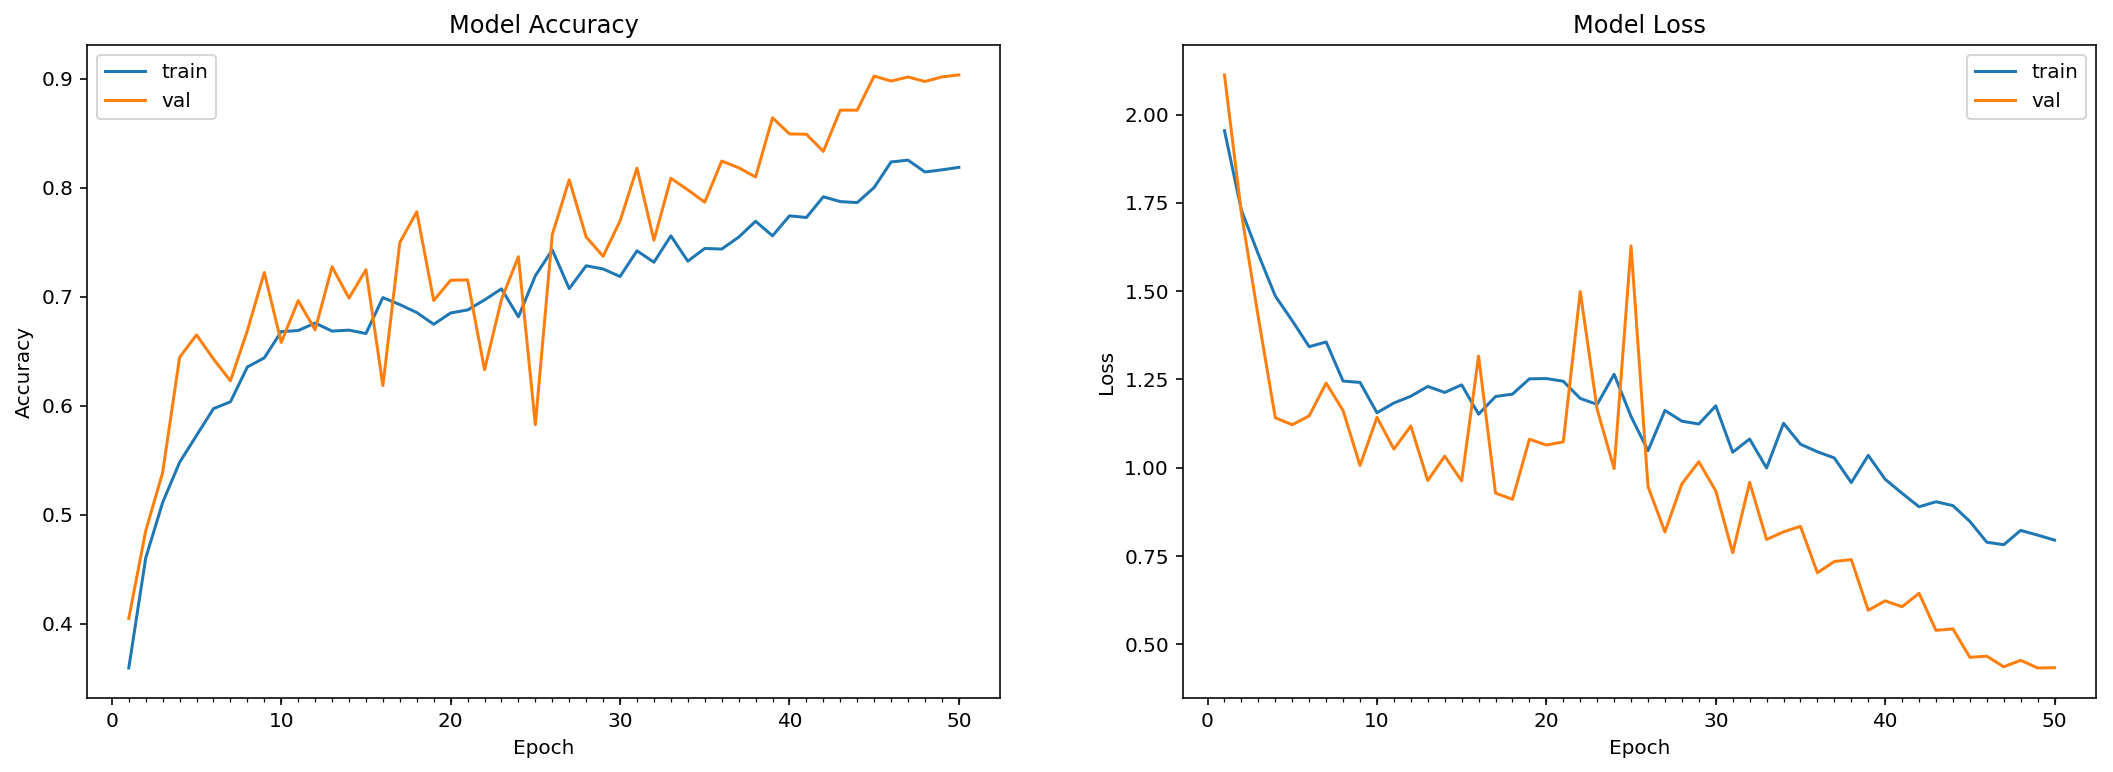

In [121]:
plot_model_history(train_history)

# Demo Cutout

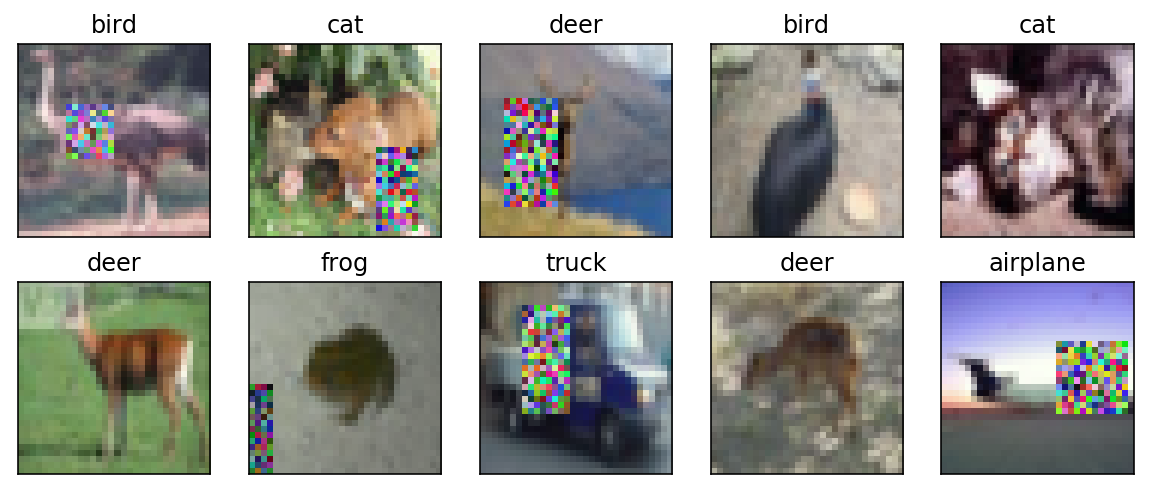

Multiple Cutouts per image


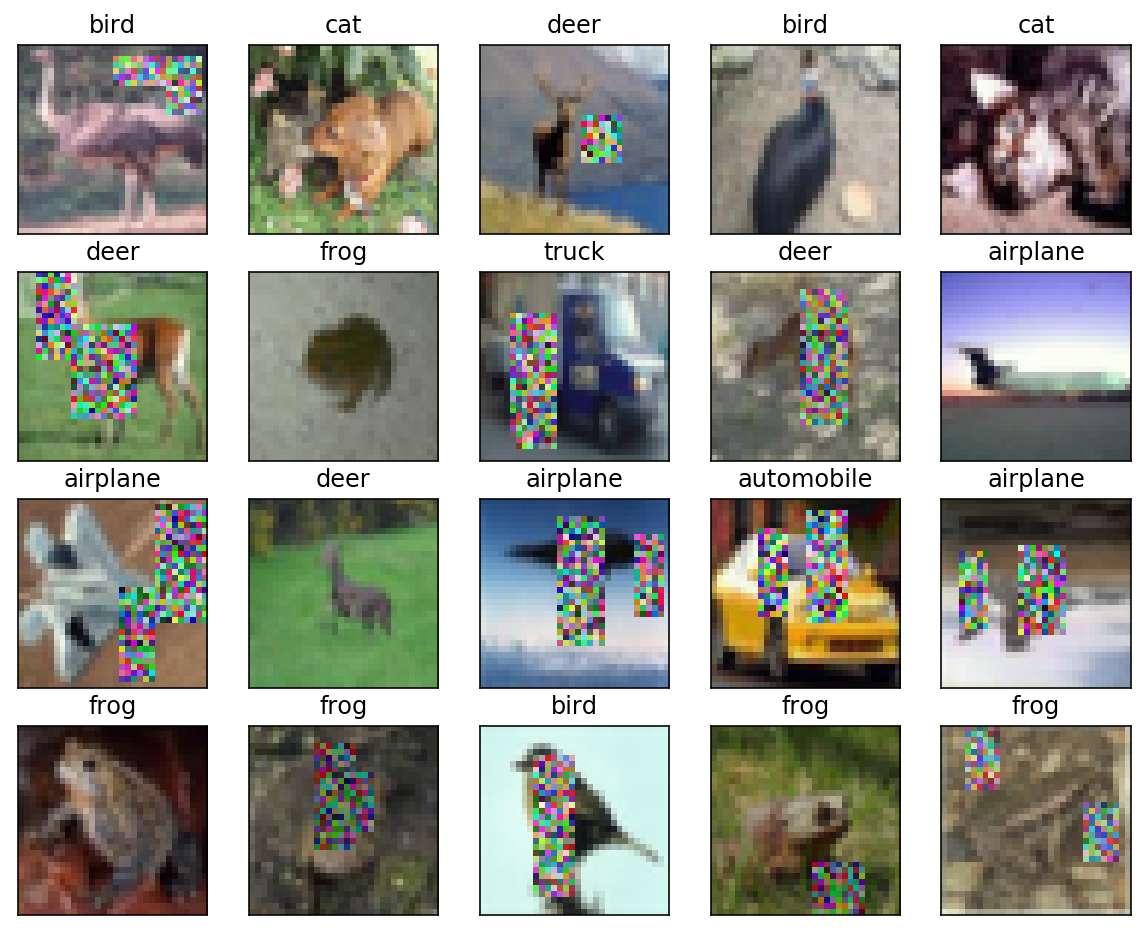

In [90]:
datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,
                             preprocessing_function=get_cutout_eraser(p=0.75, s_l=0.05, s_h=0.2, r_1=0.3, r_2=1 / 0.3, max_erasures_per_image=1, pixel_level=True))

_ = datagen.fit(X_train)
train_iterator = datagen.flow(X_test, Y_test, batch_size=100,shuffle=False)

X_e, Y_e = train_iterator.next()
X_e = min_max_scale(X_e)
show_examples(X_e[10:20], Y_e[10:20], classes)

print("="*80)

print("Multiple Cutouts per image")

datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,
                             preprocessing_function=get_cutout_eraser(p=0.75, s_l=0.05, s_h=0.2, r_1=0.3, r_2=1 / 0.3, max_erasures_per_image=2, pixel_level=True))

_ = datagen.fit(X_train)
train_iterator = datagen.flow(X_test, Y_test, batch_size=100,shuffle=False)

X_e, Y_e = train_iterator.next()
X_e = min_max_scale(X_e)
show_examples(X_e[10:30], Y_e[10:30], classes)

# Demo RICAP

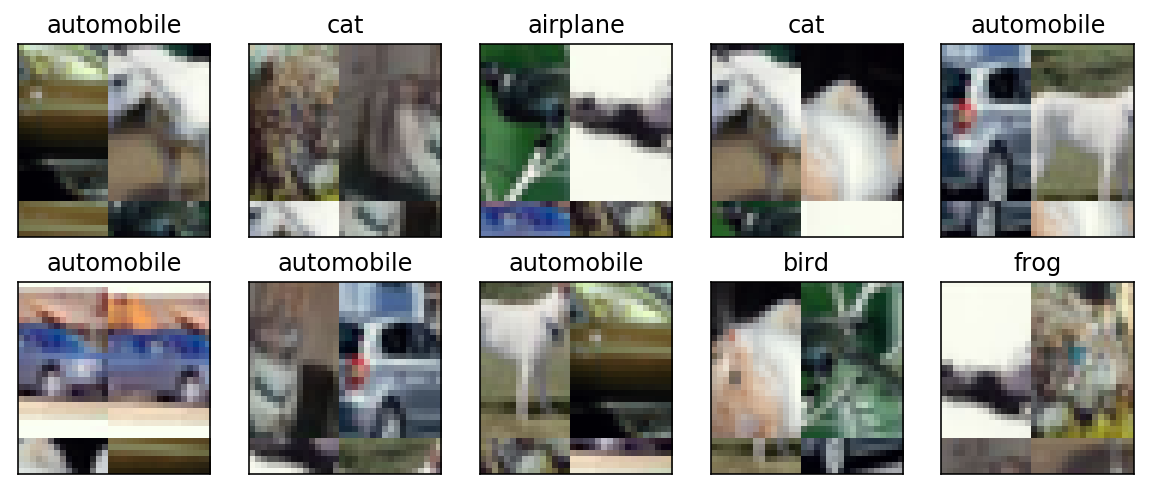

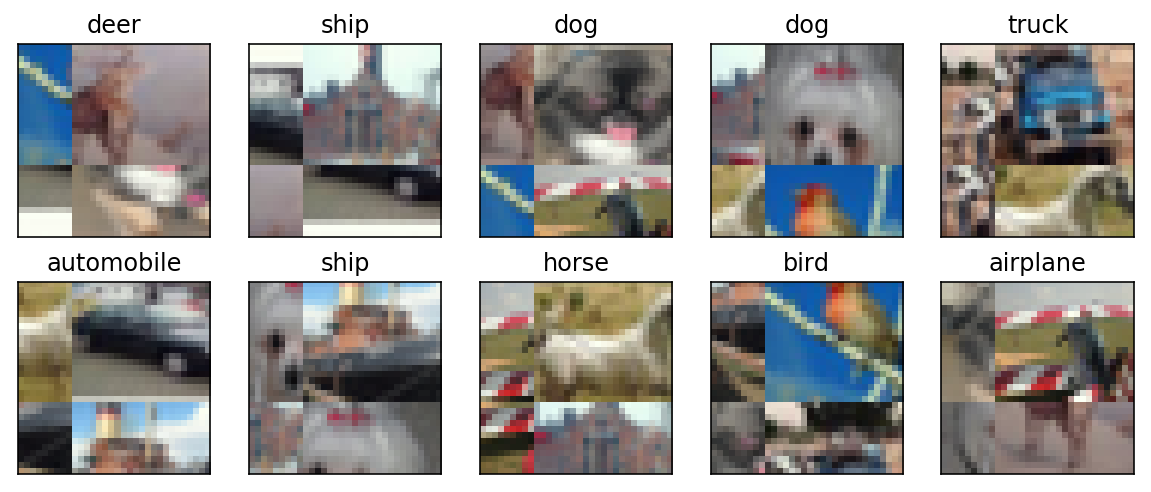

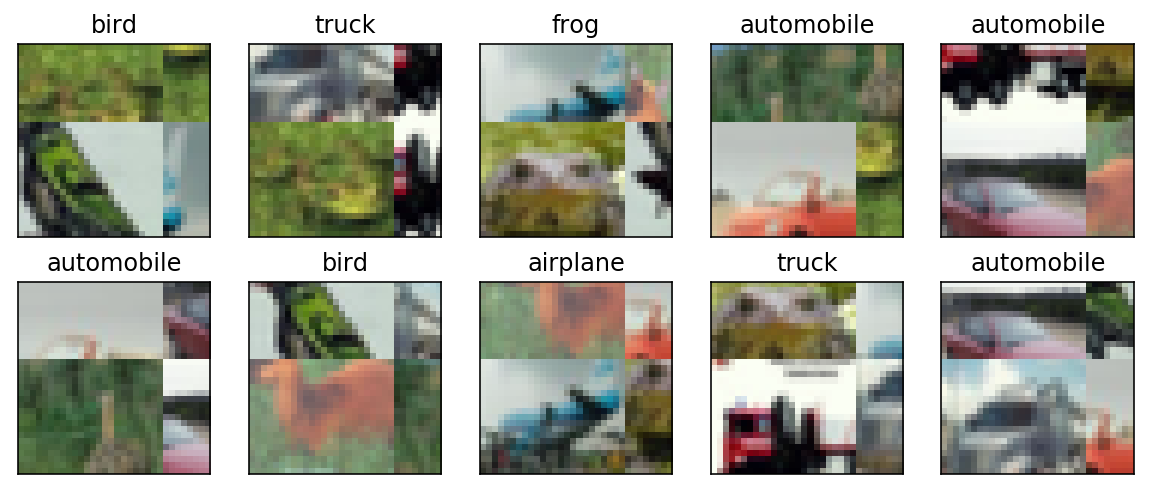

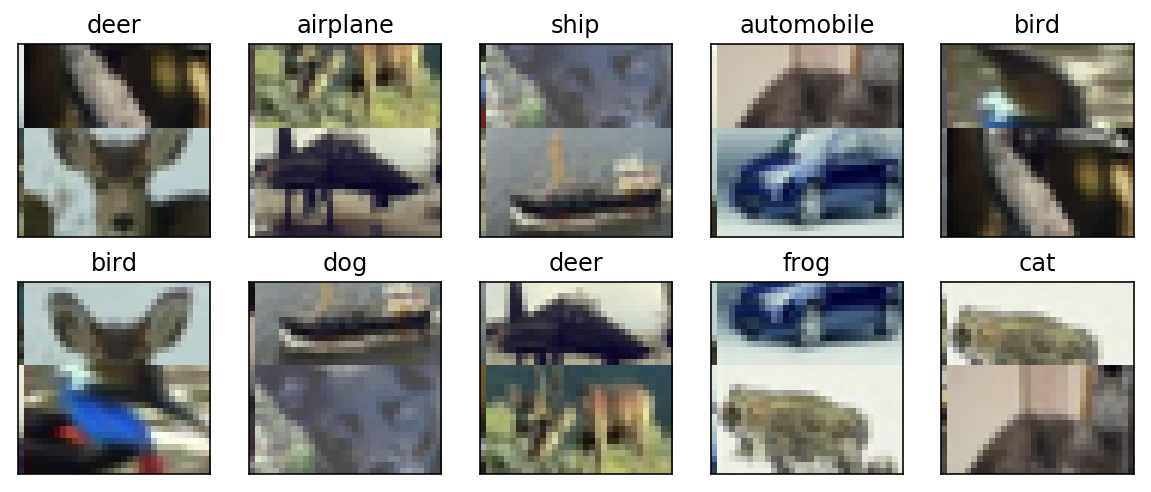

In [88]:
X_train, Y_train, X_test, Y_test = get_cifar10_data(preprocess=False)
datagen = RICAPGenerator(batch_size=100,samples=X_train.shape[0],featurewise_center=True,featurewise_std_normalization=True)
_ = datagen.fit(X_train)
train_iterator = datagen.flow(X_train, Y_train, batch_size=10,shuffle=True)

X_e, Y_e = train_iterator.next()
X_e = min_max_scale(X_e)
show_examples(X_e[0:10], Y_e[0:10], classes)

print("="*80)

X_e, Y_e = train_iterator.next()
X_e = min_max_scale(X_e)
show_examples(X_e[0:10], Y_e[0:10], classes)

print("="*80)

X_e, Y_e = train_iterator.next()
X_e = min_max_scale(X_e)
show_examples(X_e[0:10], Y_e[0:10], classes)

print("="*80)

X_e, Y_e = train_iterator.next()
X_e = min_max_scale(X_e)
show_examples(X_e[0:10], Y_e[0:10], classes)

# Demo Cutout+Ricap

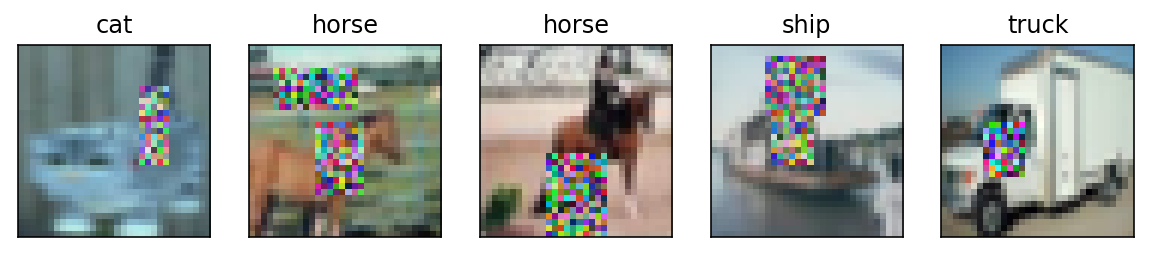

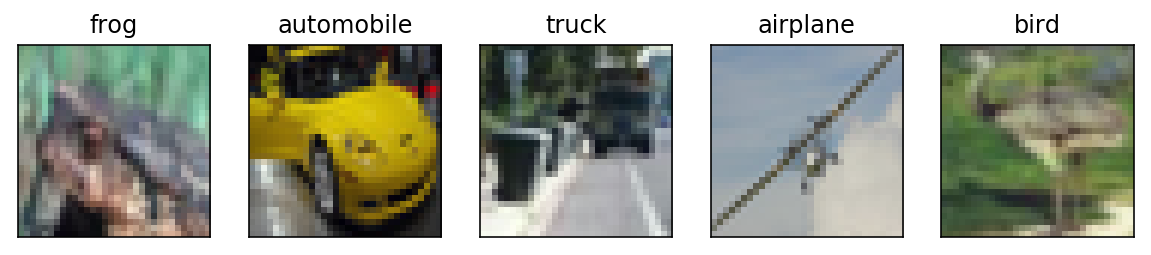

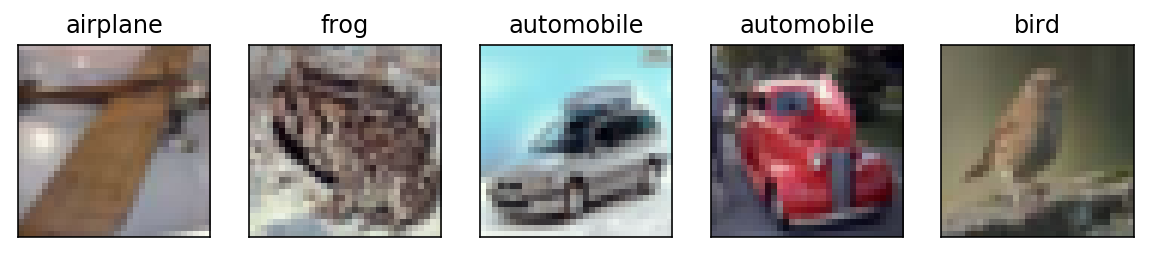

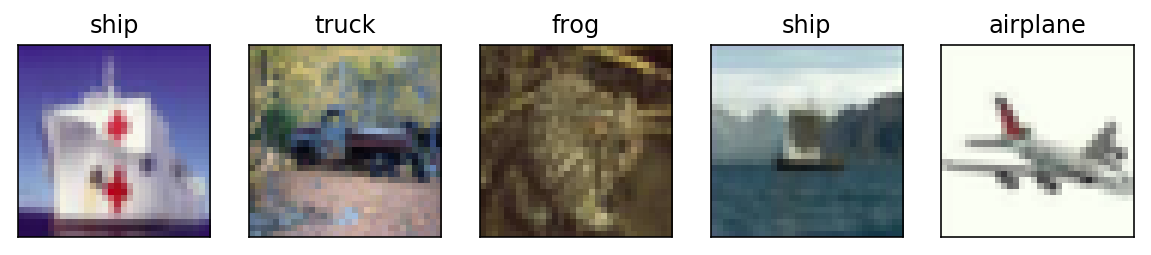

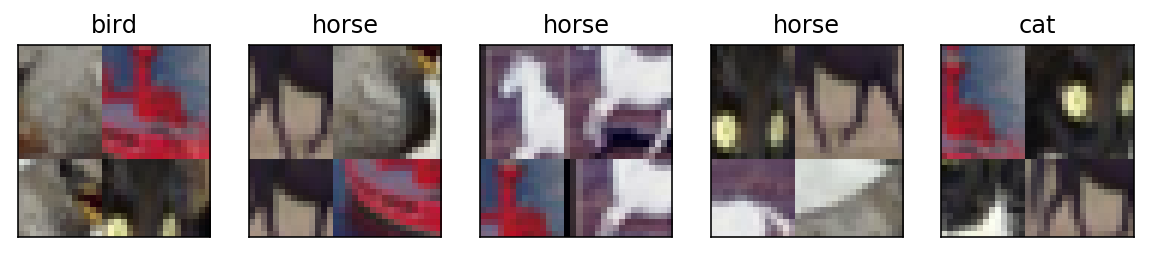

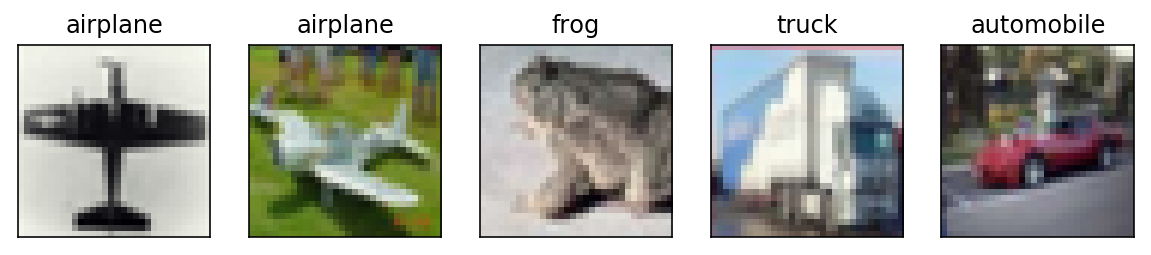

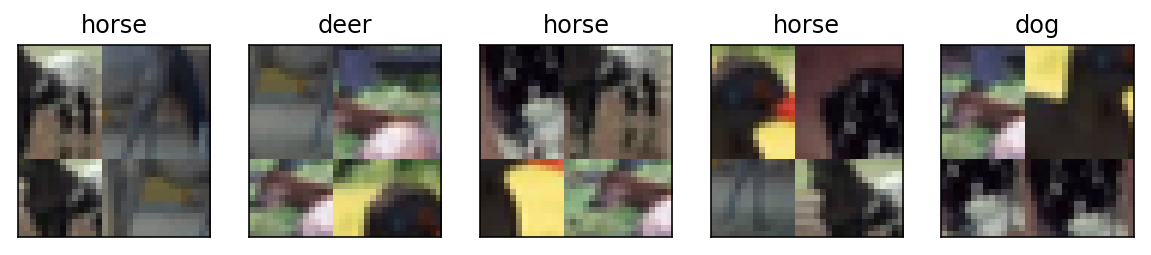

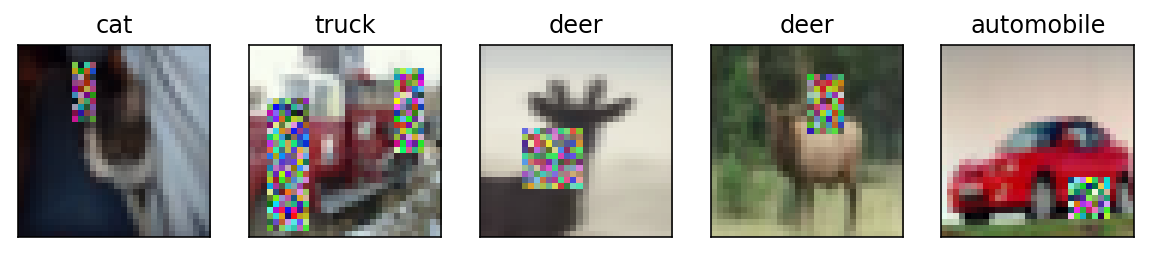

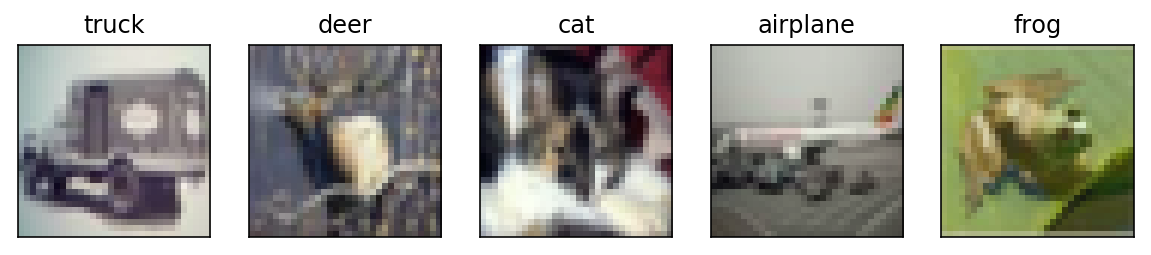

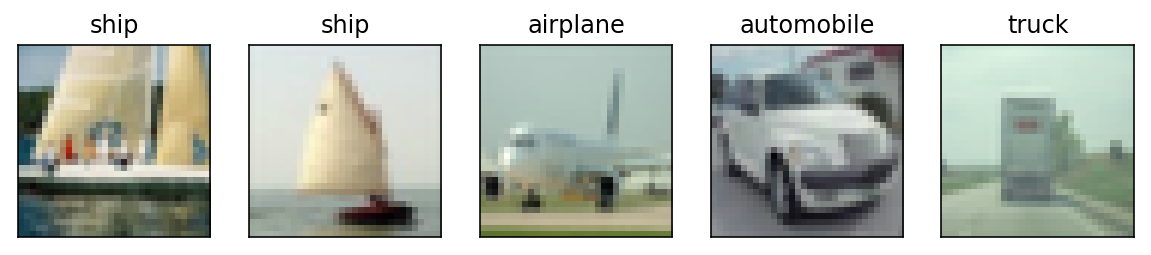

In [116]:
datagen = RicapCutoutGenerator(batch_size=5,samples=X_train.shape[0],featurewise_center=True,featurewise_std_normalization=True)
_ = datagen.fit(X_train)
train_iterator = datagen.flow(X_train, Y_train, batch_size=5,shuffle=True)

for i in range(10):
  X_e, Y_e = train_iterator.next()
  X_e = min_max_scale(X_e)
  show_examples(X_e[0:5], Y_e[0:5], classes)

  print("="*80)
